<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 1 </H3>
<hr style="height:2px;border:none"/>

## Integrantes

* Andrés Huerta - 201473544-8 - andres.huerta.14@sansano.usm.cl
* Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl



<hr style="height:2px;border:none"/>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.svm import SVC as SVM #SVC is for classification
from ipywidgets import interactive
from sklearn.tree import DecisionTreeClassifier as Tree
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.neighbors import KNeighborsClassifier as KNN
import pandas as pd
import urllib.request, re
from PIL import Image
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.multiclass import OneVsRestClassifier
from geopy.distance import great_circle
from sklearn.svm import LinearSVR
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers
from sklearn.cluster import KMeans as KM
import scipy.io as sio
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


<hr style="height:2px;border:none"/>
# Tipos de fronteras en clasificación
<hr style="height:2px;border:none"/>

In [27]:
def do_gaussianXOR(n1=250,n2=250):
    rng = np.random.RandomState(0)
    u = 0.5
    std = 0.3 #el ruido se agrega aca
    primer_c = rng.normal(loc=[u,u],scale=std,size=(n1,2))
    segundo_c = rng.normal(loc=[-u,u],scale=std,size=(n2,2))
    tercer_c = rng.normal(loc=[-u,-u],scale=std,size=(n1,2))
    cuarto_c = rng.normal(loc=[u,-u],scale=std,size=(n2,2))
    X_train = np.vstack((primer_c,segundo_c,tercer_c,cuarto_c))
    Y_train = np.hstack((np.zeros(n1),np.ones(n2),np.zeros(n1),np.ones(n2)))   
    X_test = rng.uniform(low=-1.0,high=1.0,size=( (n1+n2),2))
    Y_test = np.logical_xor(X_test[:,0] > 0, X_test[:,1] > 0)
    return X_train,Y_train,X_test,Y_test

> **a) Construya el conjunto de datos (*dataset*) y describa el proceso de creación de éstos. Determine cuántos registros contiene cada conjunto y visualı́celos.**

Se define un randomizador que agregara puntos en el plano cartesiano para los cuatro cuadrantes siguiendo una distribución normal con medias entre [-0.5, 0.5] dependiendo del cuadrante en el cual se agregue, además se establece una desviación estandar de 0.3, se distribuyen los puntos en el set de entrenamiento y se establecen a que clase corresponde cada uno en el set y_train, luego se genera un espacio de testing.

In [28]:
X_train,Y_train,X_test,Y_test = do_gaussianXOR()

In [29]:
print("Dimensiones conjunto de entrenamiento: "+ str(X_train.shape))
print("Dimensiones conjunto de pruebas: "+ str(X_test.shape))

Dimensiones conjunto de entrenamiento: (1000, 2)
Dimensiones conjunto de pruebas: (500, 2)


El conjunto de entrenamiento cuenta con 1000 ejemplos bi-dimensionales, correspondientes a las coordenadas x e y. El conjunto de pruebas contiene 500 ejemplos.

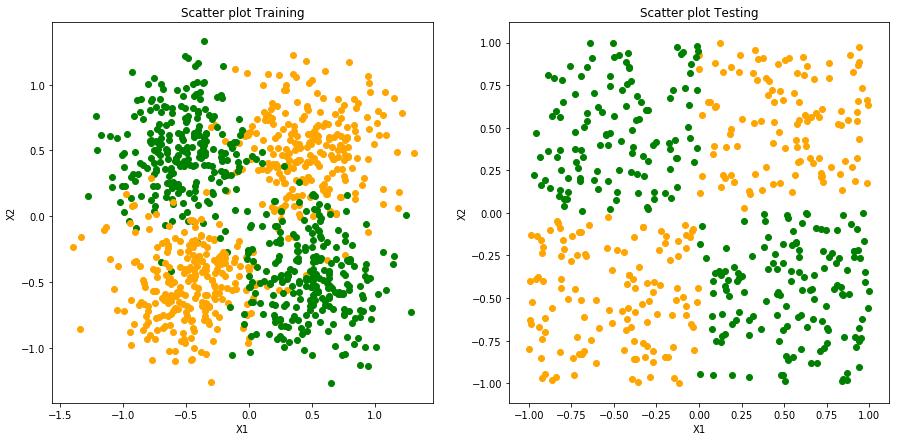

In [30]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.title("Scatter plot Training")
plt.xlabel("X1")
plt.ylabel("X2")
for i in range(len(X_train)):
  if Y_train[i] == 0:
    plt.scatter(X_train[i,0],X_train[i,1], c="orange")
  else:
    plt.scatter(X_train[i,0],X_train[i,1], c="green")
plt.subplot(122)
plt.title("Scatter plot Testing")
plt.xlabel("X1")
plt.ylabel("X2")
for i in range(len(X_test)):
  if Y_test[i] == 0:
    plt.scatter(X_test[i,0],X_test[i,1], c="orange")
  else:
    plt.scatter(X_test[i,0],X_test[i,1], c="green")
plt.show()

Se puede observar la distribución espacial de ambos conjuntos. En el conjunto de entrenamiento se logran ver los efectos del ruido gaussiano aplicado, lo que hace que puntos de una clase se encuentren en un cuadran incorrecto si se considera que estos puntos originalmente representan una función XOR, esto afectará al momento de definir las fronteras de clasificación en una SVM de margenes rígidos. También probablemente incida en el número de reglas necesarias en un árbol de clasificación y en el número de neuronas de una capa oculta en una Red Neuronal Feed-Forward.

En cambio, en el conjunto de pruebas, en el cual no fue aplicado el ruido gaussiano, todos los puntos de una clase se encuentran en el cuadrante definido por la función XOR.

In [31]:

def visualize_border(model,x,y,title=""):
    fig, axis = plt.subplots(1, 1,figsize=(12, 6))

    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) #or predict_proba
    Z = Z.reshape(xx.shape)
    Zplot = Z > 0.5

    axis.scatter(x[:,0],x[:,1],s=50,c=y,zorder=10,cmap=plt.cm.winter)
    axis.contour(xx, yy, Z,levels=[-1, 0, 1])
    axis.pcolormesh(xx, yy, Zplot ,cmap=plt.cm.YlGn)
    plt.title(title)
    plt.show()

> **b) Entrene el clasificador Linear Discriminant Analysis (LDA) y visualice la frontera de decisión que define este algoritmo. Comente cualitativamente lo que observa.**

In [32]:
def do_LDA(X, Y):
  model = LDA()
  model.fit(X, Y)
  return model

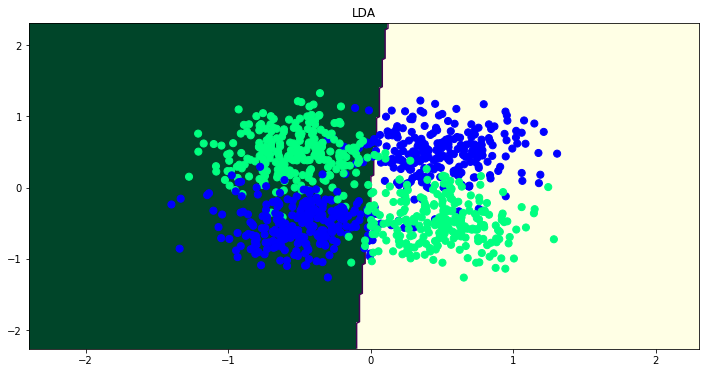

In [33]:
lda = do_LDA(X_train, Y_train)
visualize_border(lda, X_train, Y_train, "LDA")

La frontera definida por LDA es lineal, por lo que es de esperar malos resultados dado que el problema no es linealmente separable en el espacio utilizado.

Debería tener el mismo comportamiento que un clasificador que elija de manera aleatoria que clase asignar, dado  que se observa que la frontera obtenida clasificará mal aproximadamente el 50% de los datos.  No podría tener más accuracy debido que al mover la frontera de su posición se desbalancearía hacia alguna de las clases, aumentando el número ejemplos mal clasificados de la otra clase.

> **c) Entrene el clasificador Quadratic Discriminant Analysis (QDA) y visualice la frontera de decisión que define este algoritmo. Analice cualitativamente lo que observa y compare con LDA, en qué difieren y en qué se asemejan ¿Qué distribución de probabilidad asumen cada uno?**

In [34]:
def do_QDA(X, Y):
  model = QDA()
  model.fit(X, Y)
  return model

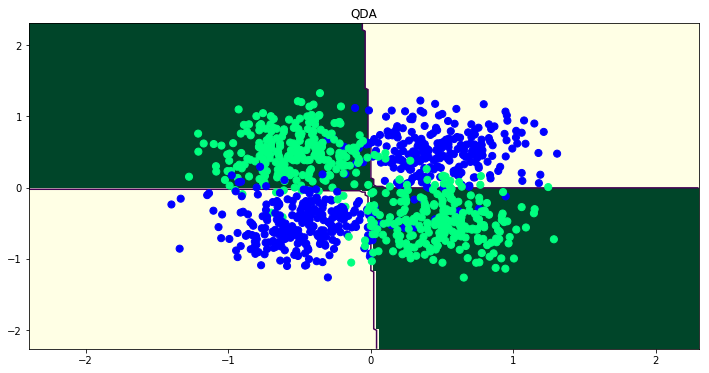

In [35]:
qda = do_QDA(X_train, Y_train)
visualize_border(qda, X_train, Y_train, "QDA")

A diferencia de LDA, se puede ver que QDA si logra definir fronteras de clasificación que logren separar las clases del problema, esto debido a que la forma de sus fronteras es Cuadráticas. Esto se debe a que QDA impone que la verosimilitud $p(x|y)$ sigue una distribución normal, casi siempre distinta para cada clase. En cambio LDA impone que las matrices de covarianza de cada clase sean iguales, lo que lleva a fronteras lineales al optimizar la función verosimilitud.

> **d) Demuestre experimentalmente que una Máquina de Vectores de Soporte (SVM) Lineal no puede resolver el problema, para esto construyala a través de sklearn. Mediante la widget interactiva explore diferentes valores del parámetro de regularización  $C$. Analice cualitativamente lo observado, para validar su análisis cualitativo calcule el accuracy sobre el conjunto de pruebas. **

Param C=  0.1
Test Accuracy:  0.486


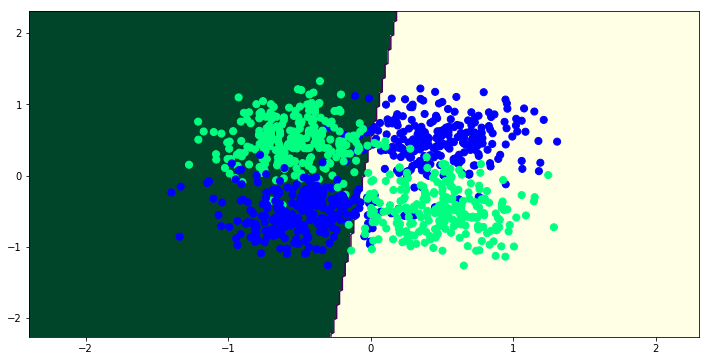

In [36]:
def train_model(param, kernel='linear', degree=3):
    model= SVM()
    C = 10**(param)
    print("Param C= ",C)
    model.set_params(C=C,kernel=kernel, degree=degree)
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model

def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model,X_train,Y_train) #here choose train/test or both!
    
p_min = -6 #define your range
p_max = 4 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

Se prueban distintos parámetros de regularización $C =   [10^{-6},10^{-5}, 10^{-4}, 10^{-3}, 10^{-2},10^{-1}, 10^{0}, 10^{1}, 10^{2}, 10^{3}, 10^{4}]$ . Para valores menores que $10^{-2}$ se obtiene la misma accuracy de $0.466$ y no se observa que se mueva la frontera de clasificación. Al utilizar valores más altos para el parámetro de regularización la Accuracy se mueve entre $0.47$ y $0.48$, además que la frontera se mueve levemente.

Un clasificador aleatorio obtendría una Accuracy de $0.5$, por lo que los resultados de la SVM lineal no logran superarlo, por lo que no estaría resolviendo el problema.

>** e) Demuestre experimentalmente que una Máquina de Vectores de Soporte (SVM) no Lineal puede resolver el problema, para ésto construya una SVM no Lineal a través de un **kernel**. Mediante la *widget* interactiva explore diferentes valores del parámetro de regularización $C$ y con diferentes kernels. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.**

Para resolver el problema utilizando una SVM es necesario que esta encuentre fronteras no-lineales. Esto se puede lograr mediante la utilización del denomindado _**Kernel-Trick**_. La idea de fondo para lograr esto es transformar el espacio de la representación a un espacio que sea linealmente separable mediante una función de transformación $\phi$, donde este nuevo espacio tiene que tener una alta dimensionalidad, debido que el _**Teorema de Cover**_ dice que la probabilidad de tener un conjunto linealmente separable aumenta con la dimensionalidad del espacio. El problema que al aumentar la dimensionalidad del espacio de la representación aumenta mucho el costo computacional del entrenamiento. Para evitar lo anterior, se plantea utilizar una función _**Kernel**_ ($K$), el cual tiene la característica que $\phi(x)^{T}\phi(x^{'}) = K(x, x^{'})$, por lo que es posible utilizar el espacio transformado mediante productos puntos en el espacio original, evitando el costo computacional que conlleva el aumento de dimensionalidad de la transformación. El problema de optimización que tiene la SVM no incluye productos puntos, pero su problema dual sí, por lo que es posible utilizar el _**kernel-trick**_ para resolverlo.

Esto provocará que las fronteras lineales en el espacio transformado correspondan a fronteras no lineales en el espacio original, por lo que se podrá resolver el problema XOR con perturbación gaussiana.


Param C=  0.1
Test Accuracy:  0.92


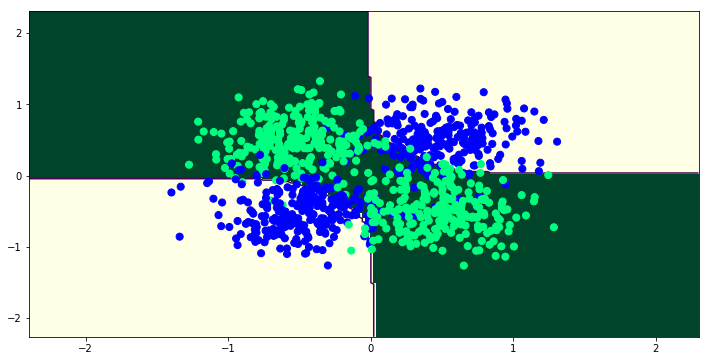

In [37]:
p_min = -6 #define your range
p_max = 4 #define your range
def visualize_border_kernel(param, kernel='linear', degree=3):
    model = train_model(param, kernel, degree)
    visualize_border(model,X_train,Y_train)
    
interactive(visualize_border_kernel,param=(p_min,p_max))

Se intentó resolver el problema con 3 tipos de kernel: Lineal, RBF y Polinomial. También está la posibilidad de utilizar un kernel Sigmoidal, pero este no cumple con todas las condiciones requeridas para ser un kernel, aunque en determinados casos da buenos resultados.

Al utilizar un kernel **lineal** no se logra resolver el problema, pues mantiene el mismo espacio original, solo cambia la métrica del problema.

Utilizando un kernel **RBF** (Radial Basis Function), el cual es un kernel que lleva a un espacio infinito-dimensional. En este caso el parámetro $C$ controla el trade-off entre la clasificación correcta de los elementos del conjunto de entrenamiento y la maximización del margen. En este caso, utilizando un $C$ menor o igual a $0.01$ se obtiene una Accuracy en el conjunto de testing de $0.962$, lo que resuelve el problema, donde las fronteras de clasificación observadas son muy similares a las definidas por QDA. Al aumentar C entre $0.01 y 1$ aumenta la Accuracy llegando a un máximo de $0.984$ cuando $C = 1$. Al aumentar $C$ aún más comienza a bajar el Accuracy, llegando a $0.956$, esto debido a que se comienza a privilegiar la correcta clasificación de los ejemplos del conjunto de entrenamiento por sobre el margen, por lo que la perturbación gaussiana aplicada a este conjunto comienza a influir en el entrenamiento. Cabe destacar que a medida que se aumenta el valor de $C$ la frontera de clasificación tiene formas cada vez más raras.

Al utilizar un kernel **Polinomial** los resultados dependen del grado del polinomio utilizado para la transformación, además del valor del parámetro de regularización. Por ejemplo en el caso del kernel polinomial de grado 4 se puede pasar de una Accuracy de $0.664$ con $C= 10^{-6}$ a  $0.964$ con $C = 100$. En cambio, con un kernel polinomial de grado 5 no se logra pasar de los $0.53$ independiente del valor de C. Expllorando distintos valores para el grado del polinomio y para el valor del parámetro de regularización se puede observar que los polinomios de grado impar no logran obtener buenos resultados independientes del parámetro de regularización. Mientras que los kernel de grado par si pueden resolverlo si se setea bien el valor para el parámetro de regularización, donde por lo general necesitan de un valor de $C$ más alto, llevando a la frontera de clasificación a una forma similar a la encontrada por QDA y SVM con RBF (con $C = 1$).

>** f) Demuestre experimentalmente que un Árbol de Decisión de múltiples niveles puede resolver el problema ¿Qué pasa con un nivel? Para ésto contruya el Árbol de Decisión a través de *sklearn*, puede utilizar el criterio y la función de partición que prefiera. Mediante la *widget* interactiva explore diferentes valores del parámetro de máxima profundidad del árbol. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.**

Se construye un árbol de decisión para resolver este problema de clasificación. Este método define particiones recursivas sobre el espacio de características, definiendo reglas de predicción para cada partición. Las reglas de predicción generan fronteras perpendiculares a los ejes, por lo que es de esperar que un árbol de un nivel genere una frontera similar a las de LDA y SVM lineal, pero de manera perpendicular a uno de los ejes, por lo que no resolvería el problema, obteniendo una Accuracy en test menor a la que obtendría un clasificador aleatorio. Ya con el segundo nivel se esperarían mejores resultados, debido que se podrían generar 4 regiones en el espacio de características, donde cada uno correspondería a un cuadrante, aunque el ruido gaussiano aplicado influirá en estas regiones.

Se utiliza el Índice de Gini como medida de la impureza de un nodo, como criterio se utiliza el mejor split. Esto debido a que son los valores por defecto utilizados por la librería _sklearn_.

Depth=  20
Test Accuracy:  0.914


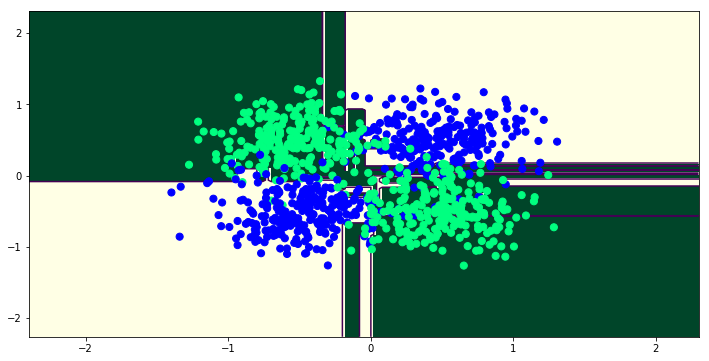

In [38]:
def train_model_tree(param):
    model = Tree()
    print("Depth= ",param)
    model.set_params(max_depth=param,criterion='gini',splitter='best')
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model

def visualize_border_interactive_tree(param):
    model = train_model_tree(param)
    visualize_border(model,X_train,Y_train) #here choose train/test or both!

p_min = 1 #define your range
p_max = 40 #define your range
interactive(visualize_border_interactive_tree,param=(p_min,p_max))

Efectivamente al utilizar un solo nivel no se puede resolver el problema, llegando a una frontera perpendicular al eje $x$, la cual logra un accuracy en el conjunto de test de $0.478$. Con dos niveles se alcanza una accuracy de $0.746$, donde las fronteras definen 4 cuadrántes, los cuales fueron afectados por el ruido presente en el conjunto de entrenamiento, desplazando las fronteras hacia la derecha. Con tres niveles se generan suficientes particiones para lograr una accuracy de $0.97$ en el conjunto de testing, la cual disminuye levemente al aumentar el número de niveles. Esto se debe al sobreajuste al ruido del conjunto de entrenamiento, debido que este tipo de modelo es muy suceptible al overfitting.

> **g) Demuestre experimentalmente que una red neuronal artificial con 1 capa escondida puede resolver satisfactoriamente el problema. Para esto construya un perceptrón multi-capa, con una capa escondida, variando el número de neuronas $N_h$ a través de la *widget* interactiva. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.**

Se genera una red neuronal artificial con una capa oculta, la cual utiliza la función rectificadora (Relu) como función de activación. Las capas de una red neuronal artificial son transformaciones que se van aplicando, donde el resultado final se puede ver como el resultado de aplicar una composición de transformaciones de las capas al input inicial. Las capas ocultas son las que aplican las transformaciones. Cada dimensión de una activación una capa (resultado de la transformación) está definida por una neurona que la computa, por lo que el número de neuronas está relacionada con el número de dimensiones de cada activación. Al tener más dimensiones es más probable que se pueda separar linealmente las clases, por lo que la accuracy debería subir con el número de neuronas.

Para ver el efecto que trae el número de neuronas se visualizan las fronteras de clasificación para distinto número de neuronas, correspondientes a las primeras 10 potencias de 2.

Neuron hidden =  32
Test Accuracy:  0.9420000028610229


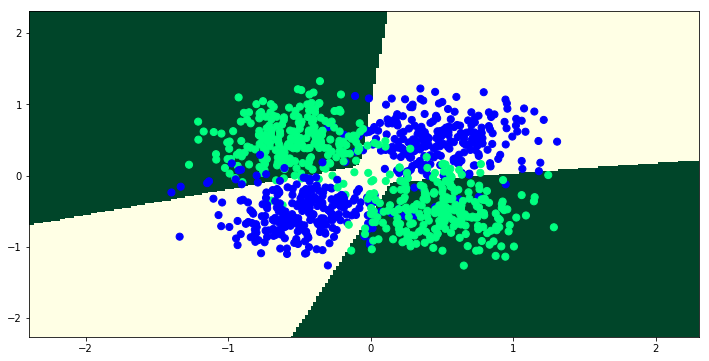

In [39]:
def train_model(param):
    n_h=2**(param)
    print("Neuron hidden = ",n_h)
    model = Sequential()
    model.add(Dense(n_h, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(X_train, Y_train, epochs=25, batch_size=128, verbose=0)
    print("Test Accuracy: ",model.evaluate(X_test, Y_test,batch_size=128,verbose=0)[1])
    return model

p_min = 0 #define your range
p_max = 10 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

Al utilizar una sola neurona en la capa oculta se obtiene una frontera lineal con una Accuracy de $0.63$, la que si bien obtiene un resultado mejor que LDA y SVM lineal, podría mejorarse al aumentar el número de neuronas.

Al llegar a 8 neuronas ocultas se logra una accuracy de $0.91$, logrando separar mayoritariamente las clases del problema. Al aumentar a 16 neuronas se logra una accuracy de $0.96$. Al utilizar 32 neuronas se logra una accuracy de $0.98$, superando el desempeño de todos los modelos anteriores. Las fronteras de clasificación son similares a una separación por cuadrantes, pero donde la separación es ligeramente curva entre ellos. Con 64 neuronas se logra una accuracy de $0.998$, logrando clasificar la gran mayoría del conjunto de entrenamiento.

Debido al optimizador utilizado (SGD), no siempre se logra la misma accuracy para el mismo número de neuronas, pero de 32 hacia adelante nunca baja de los $0.98$, resolviendo el problema con una altisima exactitud.

> **h) Construya un algoritmo $k$-NN para la clasificación del problema. Mediante la *widget* interactiva explore diferentes valores del parámetro $k$. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.**

K-Nearest Neighbors utiliza métricas para definir la clase de un punto, asignandole la clase mayoritaria de los K vecinos más cercanos según la métrica utilizada. En este caso se utilizará la distancia euclidiana como métrica para definir a los K vecinos más cercanos.

Dada la concentración de las clases en cuadrantes, se debería obtener buenos resultados con este método. Aunque si se utiliza 1 vecino se puede dar el caso que justo el vecino más cercano sea uno de los puntos que quedan en otro cuadrante producto del ruido aplicado, por lo que al subir el número de vecinos considerados para tomar la decisión se debería minimizar el efecto del ruido.



Número de Vecinos:  13
Test Accuracy:  0.956


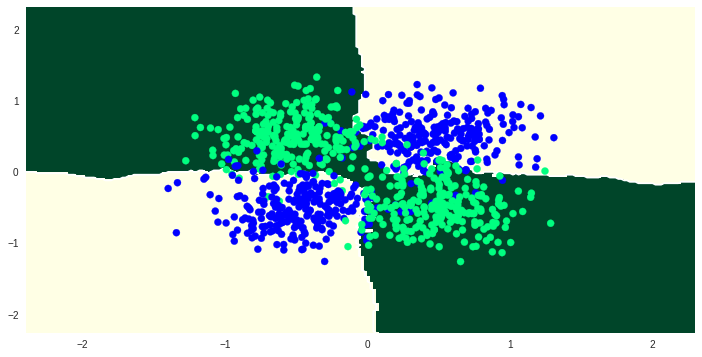

In [0]:
def train_model(param):
  vecinos = 10 * param - 10
  print("Número de Vecinos: ",vecinos)
  model = KNN()
  model.set_params(n_neighbors=vecinos)
  model.fit(X_train,Y_train)
  print("Test Accuracy: ", model.score(X_test,Y_test))
  return model
  
p_min = 1
p_max = 10
interactive(visualize_border_interactive,param=(p_min,p_max))

Al utilizar un vecino se obtiene una accuracy de $0.90$, al aumentar este número a 10 vecinos la accuracy aumenta a $0.96$, por lo que en el caso en que se utiliza 1 solo vecino, el efecto del ruido lleva a clasificar de mala manera. Al ir aumentando el número de vecinos de 10 en 10 se obtiene el máximo de accuracy al utilizar 50 vecinos $0.982$. Las fronteras generadas son similares a la de los cuadrántes, pero sin ser completamente rectas, siendo de formas arbitrariamente complejas, esta forma compleja se va suavizando a medida que se aumenta el número de vecinos considerados.

Cabe destacar que se utiliza la distancia Euclidiana como métrica de distancia para definir los vecinos más cercanos. De utilizar otra métrica se podría obtener otro tipo de fronteras de clasificación.

> **i) Vuelva a generar datos, pero ahora de manera desbalanceada por clase, con más ejemplos en una clase que en otra, pero manteniendo el conjunto de pruebas para verificación. Visualicelo apropiadamente.**

In [40]:
X_train,Y_train,X_test,Y_test = do_gaussianXOR(n1=250,n2=5)
print("Dimensiones conjunto de entrenamiento: "+ str(X_train.shape))
print("Dimensiones conjunto de pruebas: "+ str(X_test.shape))


Dimensiones conjunto de entrenamiento: (510, 2)
Dimensiones conjunto de pruebas: (255, 2)


Se generan un conjunto de entrenamiento desbalanceado por clases, donde una de las clases cuenta con 500 ejemplos y la otra clase cuenta con 10 ejemplo. En este caso el conjunto de entrenamiento tiene 510 ejemplos y el de pruebas tiene 255, pero a diferencia del conjunto de entrenamiento, el conjunto de pruebas se encuentra balanceado.

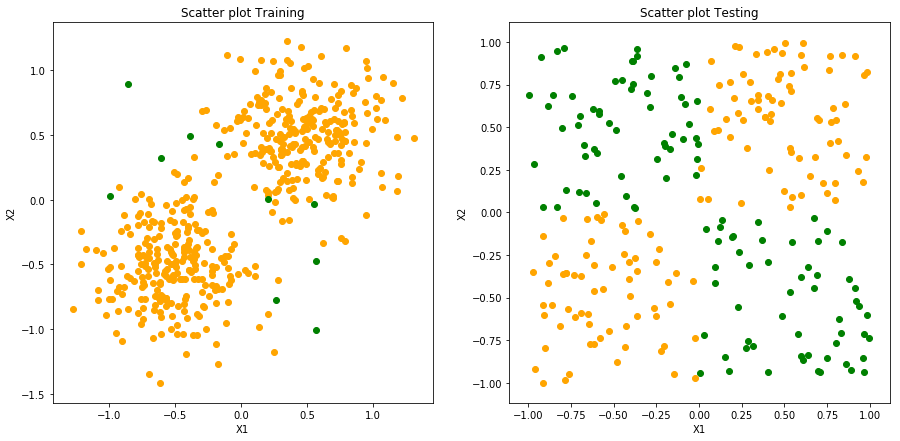

In [41]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.title("Scatter plot Training")
plt.xlabel("X1")
plt.ylabel("X2")
for i in range(len(X_train)):
  if Y_train[i] == 0:
    plt.scatter(X_train[i,0],X_train[i,1], c="orange")
  else:
    plt.scatter(X_train[i,0],X_train[i,1], c="green")
plt.subplot(122)
plt.title("Scatter plot Testing")
plt.xlabel("X1")
plt.ylabel("X2")
for i in range(len(X_test)):
  if Y_test[i] == 0:
    plt.scatter(X_test[i,0],X_test[i,1], c="orange")
  else:
    plt.scatter(X_test[i,0],X_test[i,1], c="green")
plt.show()

Le puede observar el desbalance entre las clases en el conjunto de entrenamiento. Esto llevará a obtener malos resultados al clasificar el conjunto de pruebas, el cual se puede observar que está balanceado, porque los modelos tenderán a clasificar todo con la etiqueta de la clase dominante, debido a que esto traerá mejores resultados en el entrenamiento.

> j) **Escoga las Máquinas de Soporte Vectorial con kernel RBF ($C=1$) o un Árbol de Decisión ($depth=5$) para entrenar sobre estos datos desbalanceados, mida el *Accuracy* sobre el conjunto de pruebas.**

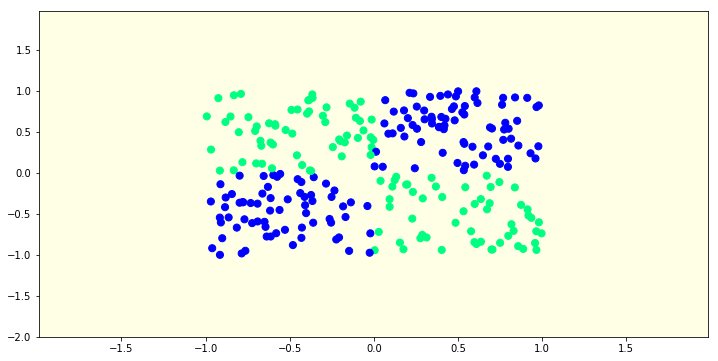

SVM Train Accuracy:  0.9803921568627451
SVM Test Accuracy:  0.5568627450980392


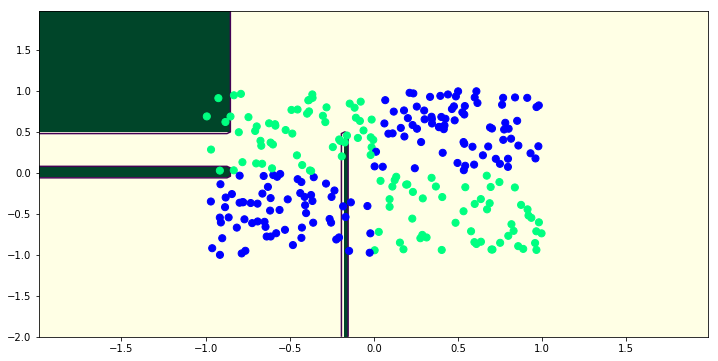

Tree Train Accuracy:  0.9882352941176471
Tree Test Accuracy:  0.5725490196078431


In [42]:

svmRBF = SVM()
svmRBF.set_params(C=1, kernel='rbf')
svmRBF.fit(X_train,Y_train)

visualize_border(svmRBF,X_test,Y_test)

print("SVM Train Accuracy: ",svmRBF.score(X_train,Y_train))
print("SVM Test Accuracy: ",svmRBF.score(X_test,Y_test))

arbolito = Tree()
arbolito.set_params(max_depth=5, criterion='gini',splitter='best')
arbolito.fit(X_train,Y_train)

visualize_border(arbolito, X_test,Y_test)

print("Tree Train Accuracy: ",arbolito.score(X_train,Y_train))
print("Tree Test Accuracy: ",arbolito.score(X_test,Y_test))

Se observa que ambos métodos obtienen malos resultados en el conjunto de pruebas, donde la SVM le coloca la misma etiqueta a todas las clases y el árbol de clasificación logra asignar algunas etiquetas a la clase con menos ejemplos, pero en muy pocos casos.

>** k) Ahora verifique que se puede mejorar la métrica a través de poner un peso en la función objetivo para las distintas clases, *seteelo* a mano o utilize la función *balanced* para que reduzca el impacto de lo datos de la clase mayoritaria en la función objetivo o que aumente el impacto de los datos de la clase minoritaria.**

Se utiliza la función balanced para los pesos de cada clase, la cual ajusta los pesos de manera inversamente proporcional a la frecuencia de las clases en el conjunto de entrenamiento.

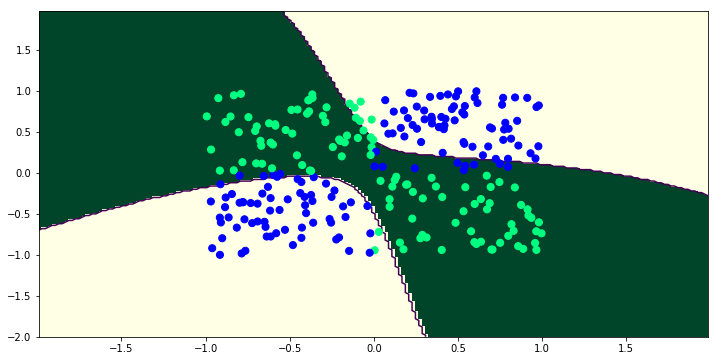

SVM Train Accuracy:  0.8725490196078431
SVM Test Accuracy:  0.8980392156862745


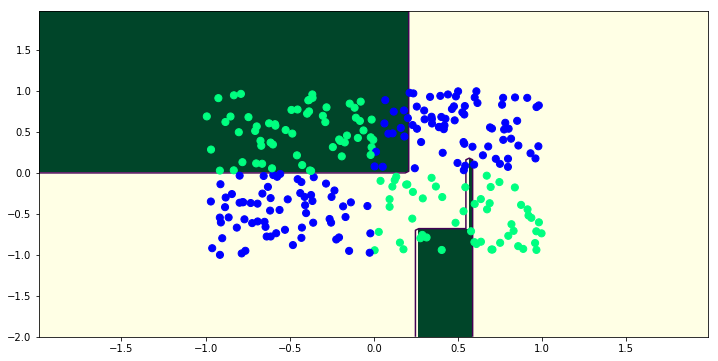

Tree Train Accuracy:  0.8921568627450981
Tree Test Accuracy:  0.7607843137254902


In [43]:
svmRBF = SVM()
svmRBF.set_params(C=1, kernel='rbf', class_weight='balanced')
svmRBF.fit(X_train,Y_train)

visualize_border(svmRBF,X_test,Y_test)

print("SVM Train Accuracy: ",svmRBF.score(X_train,Y_train))
print("SVM Test Accuracy: ",svmRBF.score(X_test,Y_test))

arbolito = Tree()
arbolito.set_params(max_depth=5, criterion='gini',splitter='best', class_weight='balanced')
arbolito.fit(X_train,Y_train)

visualize_border(arbolito, X_test,Y_test)

print("Tree Train Accuracy: ",arbolito.score(X_train,Y_train))
print("Tree Test Accuracy: ",arbolito.score(X_test,Y_test))

Se logra observar como se reduce el impacto del desbalance de clases en ambos conjuntos, donde en el caso de la SVM se logra mejores resultados en el conjunto de pruebas que en el de entrenamiento. En el caso del árbol, si bien se mejoran los resultados, hay un cuadrante de la clase con menor cantidad de ejemplo que el árbol no logra clasificar bien.

Otras técnicas que se pueden utilizar en estos casos de desbalance de clases incluyen la toma de una submuestra de la clase dominante, generar puntos de la clase minoritaria mediante el aprendizaje de la distribución de los datos existentes, entre otras técnicas posibles.

<hr style="height:2px;border:none"/>
# Un problema multilabel
<hr style="height:2px;border:none"/>

> **a) Cargue los datos del *output* del modelo (*labels*), descríbalos ¿Cuántos ejemplos hay por cada clase?**

In [3]:
y1 = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_groundtruth/Lite_GT_Train.txt",delimiter="\s",header=None)
y = y1.values
print(y.shape)
y1.head()

(27807, 81)


,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Se cuenta con 27807 ejemplos, los cuales pueden pertenecer a 81 clases diferentes.

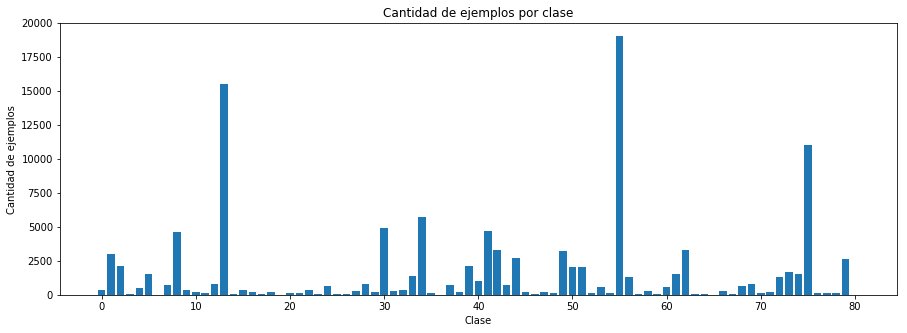

Cantidad mayor:  19052
Cantidad menor:  3


In [4]:
numeroEjemplos = list()
indices = list()
for i in y1:
    numeroEjemplos.append(np.sum(y1[i]))
    indices.append(i)

plt.figure(figsize=(15,5))
plt.title("Cantidad de ejemplos por clase")
plt.bar(indices, numeroEjemplos)
plt.xlabel("Clase")
plt.ylabel("Cantidad de ejemplos")
plt.show()

print("Cantidad mayor: ",max(numeroEjemplos))
print("Cantidad menor: ",min(numeroEjemplos))

Además, se puede observar que la cantidad de ejemplos por etiqueta está desbalanceado, donde la etiqueta con más ejemplos tiene 19052 y la que menos tiene ejemplos cuenta con solo 3. Esto podría traer problemas al asignar cada etiqueta, pues el clasificador podría asignarle la etiqueta mayoritaria a todas las imágenes, y no asignar nunca la etiqueta de la etiqueta minoritaria.

>** b) Visualice el tema de que un dato  (imagen en este caso) puede tener múltiples etiquetas. Comente sobre la definición del problema *multi-label* y cómo aplica en este caso.**

Etiquetas de la imagen : ['clouds' 'lake' 'ocean' 'water']


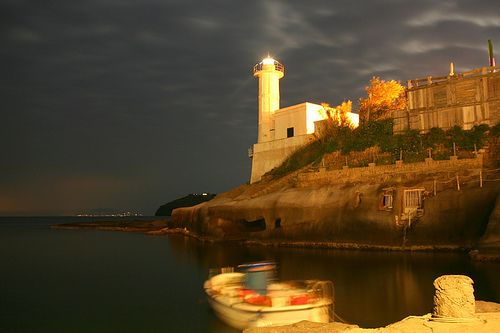

In [8]:
label_names = np.loadtxt("Concepts81.txt",dtype='object')
arch = open("NUS-WIDE-urls.txt",'r') #lectura para mapeo de link a url
regex = re.compile("\s+")
image2url = {}
for line in arch.readlines():
    aux = regex.split(line.strip())
    image = aux[0].split("Flickr\\")[-1]
    url_m = aux[3]
    image2url[image] = url_m
arch.close()
arch = open("NUS-WIDE-Lite/image list/Train_imageOutPutFileList.txt",'r')
data_urls = [image2url[line.strip()] for line in arch.readlines()]
arch.close()

"""Visualizacion"""

s = np.random.randint(0,len(data_urls)) #mostrar para una imagen random
category_sample = np.where(y[s]==1)[0] 
print("Etiquetas de la imagen :",label_names[category_sample])
im = Image.open(urllib.request.urlopen(data_urls[s]))
im

Multilabel es una extensión del problema de clasificación en el cual un input puede tener un output que es combinación de multiples labels.

En este caso se esta viendo una imagen de un paisaje en el cual existen multiples elementos que lo conforman pero la imagen no se etiqueta como el concepto de tipo de paisaje, sino que etiquetan los elementos que la conforman. Es por esto que una imagen puede tener tantas etiquetas como tipos de objetos conforman la imagen.

>** c) Comente sobre la *representación* que posee la salida de los modelos (*labels*) ¿En qué dominio habita? ¿Tiene restricciones?**

Cuando se trabaja con un problema de clasificación es necesario representar la salida como un valor número indicando la clase a la que corresponde el caso, para un caso de clasificación se puede utilizar una notación 0 y 1, para multi-clases basta con un valor numérico. En este caso en cambio, se puede utilizar un vector binario marcando un 1 cuando el elemento j del vector se encuentra dentro de la imagen i y 0 cuando no.

La representación de las etiquetas efectivamente corresponde al segundo caso, donde 0 representa que la imagen no posee el elemento que representa la etiqueta y 1 es que la imagen si presenta el elemento de la etiqueta. Es por esto que cada etiqueta tiene un dominio $DOM = {0 , 1}$. 

> **d) Decida sobre una representación, en este caso descriptores, para la entrada a los modelos (*input*), puede utilizar la mezcla entre distintos descriptores, comente sobre la elección y qué representa.**
 

Se tienen dos representaciones, la primera cuenta con los "momentos de color" de cada imagen y la segunda cuenta con un histograma de color de cada imagen.

La primera representación contiene medidas que describen la distribución de color de una imagen, para así comparar similitudes entre dos imágenes basadas en el color de estas. Los primeros tres momentos corresponden a la media, donde esta se calcula para cada canal pixel por pixel; la desviación estandar, la cual se calcula para cada canal; y el tercero es el sesgo, el cual es calculado para cada canal. 

En este caso se utilizan estos 3 momentos para 3 canales de colores. Esto para grillas de 5x5, por lo que se tiene una dimensión de 225.

La segunda representación presenta la distribución de colores de una imagen, donde cada dimensión corresponde a la cantidad de pixeles que corresponden a una cierta medida [1]. Por ejemplo, si se considera una imagen en el espacio RGB donde cada canal se separa en 4 rangos de intensidad, el histograma contendría la cantidad de pixeles para todas las combinaciones entre los grupos de los canales (64 dimensiones). Lo malo que tiene esta representación para clasificación es que, al considerar solo colores, es que la decisión depende solo del color del objeto a clasificar y no de la forma que pueda tener, por lo que dos imágenes con objetos iguales de colores distintos podrían ser consideradas como objetos totalmente distintos. También son muy afectados por ruido externo, como pueden ser cambios en la iluminación.

En este caso, la representación vive en el espacio de color LAB (L: Luminosidad negro a blanco -- A: rojo a verde -- B: gradiente del azul), el cual fue separado en 4 grupos, dejando una dimensionalidad de 64[3].




In [9]:
file = "Normalized_CM55_Lite_Train.dat" # -> 225-D block-wise color moments with each row represent an image.
file2 = "Normalized_CH_Lite_Train.dat" #-> 64-D color histogram with each row represents an image.
descriptors1 = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_features/"+file,delimiter="\s",header=None)
descriptors2 = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_features/"+file2,delimiter="\s",header=None)

descriptors, y2, descriptorsHisto, yHisto = resample(descriptors1, y, descriptors2, y, n_samples=10000)

descriptors = descriptors.values
descriptorsHisto = descriptorsHisto.values

print(descriptors.shape)
print(descriptorsHisto.shape)

(10000, 225)
(10000, 64)


Se grafican los histogramas de color para dos de las imágenes, con el objetivo se observar la forma de estos.

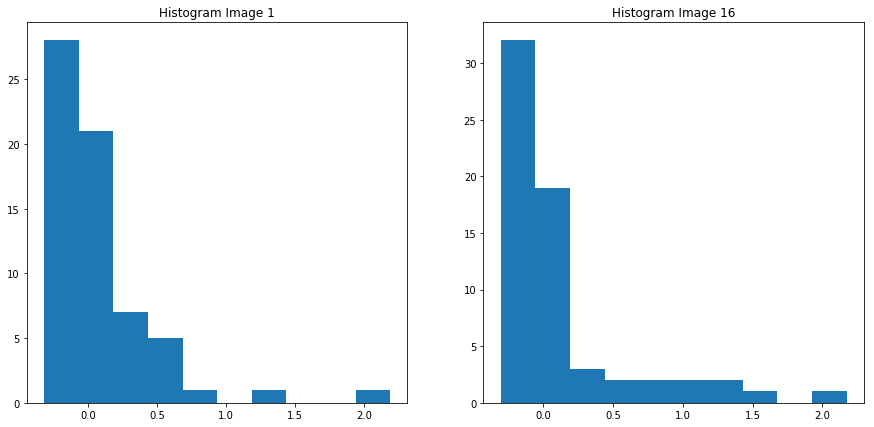

In [10]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.title("Histogram Image 1")
plt.hist(descriptorsHisto[0])
plt.subplot(122)
plt.title("Histogram Image 16")
plt.hist(descriptorsHisto[15])
plt.show()

Finalmente se decide utilizar solo una representación, la cual será la de los momentos de los colores, debido a que con estos momentos se puede describrir la distribución de colores de la imagen. Se pensó utilizar una mezcla entre las representaciones, para que se incluya el histograma de colores y los primeros tres momentos, pero el histograma corresponde a la imagen completa y los momentos corresponden a partes de la imagen, por lo que los momentos podrían no describir lo sucedido con la distribución de color de la imagen completa.

> **e) Deje un conjunto separado para evaluar los modelos y comportar como conjunto de pruebas, además de realizar la clásica estandarización de las entradas de los modelos.**

In [11]:
X_train,X_test,y_train,y_test = train_test_split(descriptors,y2,test_size=0.33)
print(X_train.shape)
print(X_test.shape)

(6700, 225)
(3300, 225)


Se separan los conjuntos de entrenamiento y de pruebas. El primero cuenta con 6700 ejemplos y el segundo con 3300 ejemplo. Cabe destacar que se realizó un muestreo de los descriptores debido a la cantidad de éstos. 

Antes de estandarizar las entradas, se realizan boxplots para las medias, las desviaciones estándar y los sesgos, con el objetivo de ver si existen outliers en los datos, pues de ser así es mejor utilizar un scaler robuzto frente outliers.

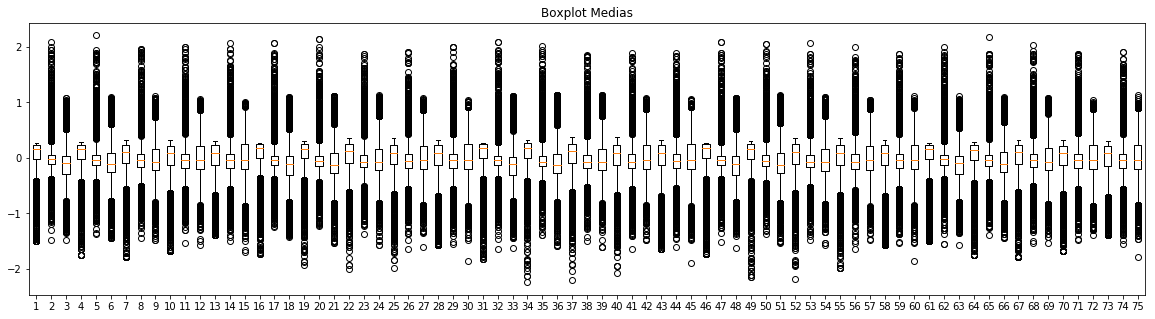

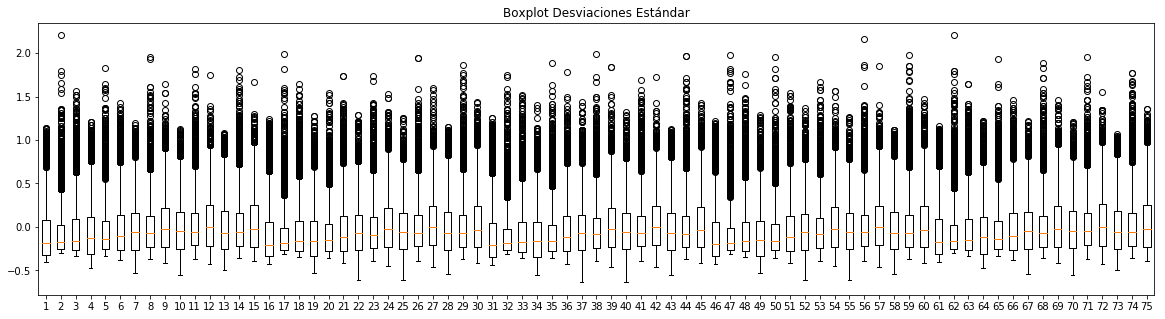

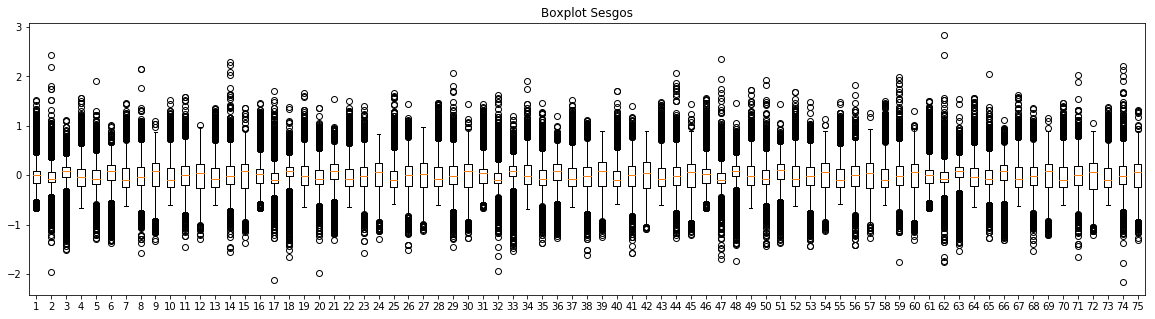

In [12]:
X_trainT = X_train.T
means = list()
devStd = list()
skew = list()
for i in range(len(X_trainT)):
    if(i%3 == 0):
        means.append(X_trainT[i])
    elif(i%3 == 1):
        devStd.append(X_trainT[i])
    else:
        skew.append(X_trainT[i])
     
plt.figure(figsize=(20,5))
plt.title("Boxplot Medias")
plt.boxplot(means)
plt.show()

plt.figure(figsize=(20,5))
plt.title("Boxplot Desviaciones Estándar")
plt.boxplot(devStd)
plt.show()

plt.figure(figsize=(20,5))
plt.title("Boxplot Sesgos")
plt.boxplot(skew)
plt.show()

Efectivamente se verifica la presencia de outliers en las 3 medidas, por lo que se utilizará un scaler robuzto frente a outliers, el cual utiliza la mediana y el rango intercuartílico para estandarizar los datos.

In [13]:
rbt = RobustScaler()
rbt.fit(X_train)
X_trainR = rbt.transform(X_train)
X_testR = rbt.transform(X_test)

std = StandardScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)


> **f) Se presenta una métrica para validar en el código a continuación, la cual mide la cantidad de aciertos a las *labels* que tenga un dato de manera normalizada. Defina otra métrica a utilizar con el propósito de validar lo mismo (el desempeño de un modelo).**

La metrica presentada corresponde al promedio de las etiquetas asignadas correctamente dividida por la cantidad de etiquetas.

In [14]:
#def evaluation_metric(y_true,y_pred):
#    suma = 0.
#    for y,yp in zip(y_true,y_pred):
#      if(np.sum(y)!= 0):
#        suma += np.dot(y,yp) / np.sum(y)  #cantidad de valores iguales / cantidad de labels totales
#      else:
#        if np.sum(yp) == 0:
#          suma += 1 # N ceros arriba / N ceros abajo
#        else:
#          a = yp.size # cantidad de labels que son 0
#          suma += (a - np.sum(yp))/a # a - np.sum(yp) son la cantidad de ejemplos correctamente clasificados con 0. 
#    return suma/float(len(y_true))

def evaluation_metric(y_true,y_pred):
    suma = 0.
    for y,yp in zip(y_true,y_pred):
        suma += np.sum(y==yp, dtype='float')/len(y)    
    return suma/float(len(y_true))


In [15]:

#Best Performance at 1
def jaccard(y_true, y_pred):
  return jaccard_similarity_score(y_true, y_pred)



La segunda metrica de desempeño ha utilizar corresponde a la puntuación de similitud de jaccard, corresponde a el tamaño de la intersección entre 2 conjuntos, en este caso y_true e y_pred, dividido por la unión de ambos sets de labels.

$$
J(a, b) = \frac{|a \cap b |}{|a\cup b|}
$$


Para calcular el desempeño del modelo se suman las puntuaciones de cada predicción y se divide por el total de casos del conjunto a evaluar.

$$ 
J(y, y_p) =\frac{1}{n} \sum_{i = 1}^{n} \frac{|y^{(i)} \cap y_p^{(i)} |}{|y^{(i)}\cup  y_p^{(i)}|}
$$

Sin embargo, a punta de prueba y error se notó que esta métrica no es la adecuada, debido a que si la imagen no contiene etiquetas, o contiene muy pocas, el valor del índice de Jaccard será 0 o muy cercano, cuando no debería ser así considerando el contexto del problema. 

Como tercera métrica a utilizar se propone la distancia euclidiana como métrica de distancia, de esta manera se podrá ver la distancia entre los dos vectores no importando el tipo de etiquetas que tenga la variable real. Esta distancia de normaliza por su valor máximo para que se mueva en un rango entre 0 y 1, con 0 el mejor valor posible.

Para observar el comportamiento de estas métricas se grafica cada una de estas con respecto a la cantidad de etiquetas asignadas correctamente.

In [16]:
ones = np.matrix(np.ones(81, dtype=int))
ones = np.asarray(ones)
zeros = np.matrix(np.zeros(81, dtype=int))
zeros = np.asarray(zeros)

met = []
jac = []
euclidians = []
met.append(evaluation_metric(zeros,ones))
jac.append(jaccard(zeros,ones))
euclidians.append(euclidean_distances(zeros,ones)[0][0]/(len(zeros[0])**(1/2)))

for i in range(len(zeros[0])):
    ones[0][i] = 0
    met.append(evaluation_metric(zeros,ones))
    jac.append(jaccard(zeros,ones))
    euclidians.append(euclidean_distances(zeros,ones)[0][0]/((len(zeros[0])**(1/2))))


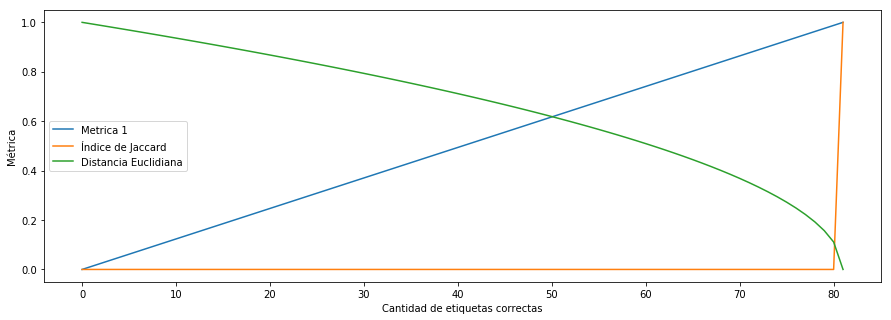

In [17]:
plt.figure(figsize=(15,5))
plt.plot(met)
plt.plot(jac)
plt.plot(euclidians)
plt.xlabel("Cantidad de etiquetas correctas")
plt.ylabel("Métrica")
plt.legend(['Metrica 1','Índice de Jaccard','Distancia Euclidiana'])
plt.show()

In [18]:
#def euclidiana(y_true, y_pred):
#    distancias = np.diagonal(euclidean_distances(y_true, y_pred))/(y_true.shape[1]**(1/2))
#    return sum(distancias)/len(distancias)
def euclidiana(y_true, y_pred):
    suma = 0.
    for y,yp in zip(y_true,y_pred):
        suma += (np.sum((y-yp)**2)**(1/2))/(len(y)**(1/2))
        
    return suma/float(len(y_true))        

>** g) Experimente en resolver el problema con un Árbol de Decisión (varíando los hiper-parámetros estructurales), el cual a través de *sklearn* se puede extender de manera sencilla a *multi-label*. Mida las métricas de desempeño definidas anteriormente sobre ambos conjuntos (entrenamiento y pruebas), comente.**

In [19]:
def do_Tree(X_train, y_train, depth=10, criterion='gini', splitter='best', min_samples_split=2, class_weight=None):
    model = Tree() 
    model.set_params(max_depth=depth,criterion=criterion, splitter='best', min_samples_split=min_samples_split,class_weight=class_weight)
    model.fit(X_train,y_train)
    return model
   

In [20]:
def cross_val(k, X_train, do_Function, depth=10,criterion='entropy', min_split = 2, pesos=None):
    kf = KFold(n_splits=k)
    euclidians = list()
    metric = list()  
    for train, val in kf.split(X_train): 
        model = do_Function(X_train[train], y_train[train],depth=depth,criterion=criterion, min_samples_split=min_split, class_weight=pesos)
        euclidians.append(euclidiana(y_train[val],model.predict(X_train[val])))
        metric.append(evaluation_metric(y_train[val],model.predict(X_train[val])))
    return [sum(euclidians)/len(euclidians),sum(metric)/len(metric)] 

Se prueban los modelos con el parametro de profundidad maximo establecido como el default y se varian los criterios entre entropy y gini, para esto se utiliza Cross Validation.

In [143]:
print(cross_val(10, X_train, do_Tree, depth = None))
print(cross_val(10, X_train, do_Tree, depth = None, criterion='gini'))

[0.20290605664908984, 0.9461857379767837]
[0.20312685635814548, 0.946145199926295]


Las diferencias obtenidas para ambos métodos son mínimas, donde para la distancia euclidiana sale mejor utilizar el Índice de Gini y para la métrica entregada sale mejor utilizar la entropía. Se utilizará el Índice de Gini debido a que es la métrica que viene por defecto en Sklearn.



A continuación se realiza validación cruzada para determinar la mejor profundidad para valores entre 1 y 20

In [147]:
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

def validation_tree1(k):
  euclidians = list()
  metrics = list()
  maxj = 1
  maxm = 0
  for i in depths:
    print("profundidad:",i)
    kf = KFold(n_splits=k)
    euclidian_v = 0
    euclidian_t = 0
    metric_v = 0
    metric_t = 0
    for train, val in kf.split(X_trainR):
      model = do_Tree(X_trainR[train], y_train[train], i, criterion='gini')
      y_pred_val = model.predict(X_trainR[val])
      y_pred_test = model.predict(X_testR)
      euclidian_v += euclidiana(y_train[val], y_pred_val)
      euclidian_t += euclidiana(y_test, y_pred_test)
      metric_v += evaluation_metric(y_train[val],y_pred_val)
      metric_t += evaluation_metric(y_test, y_pred_test)
        
    euclidian_v = euclidian_v / k
    euclidian_t = euclidian_t / k
    metric_v = metric_v / k
    metric_t = metric_t / k
    if(euclidian_v <= maxj):
        maxj = euclidian_v
        print("El maximo es maxj, con una profundidad de:",i)
    if(metric_v >= maxm):
        maxm = metric_v
        print("El mínimo es maxm, con una profundidad de:",i)
    euclidians.append((euclidian_v, euclidian_t)) 
    metrics.append((metric_v, metric_t))
  return euclidians, metrics

In [148]:
eucls, mets = validation_tree1(10)

profundidad: 1
El maximo es maxj, con una profundidad de: 1
El mínimo es maxm, con una profundidad de: 1
profundidad: 2
El maximo es maxj, con una profundidad de: 2
El mínimo es maxm, con una profundidad de: 2
profundidad: 3
El maximo es maxj, con una profundidad de: 3
El mínimo es maxm, con una profundidad de: 3
profundidad: 4
El maximo es maxj, con una profundidad de: 4
El mínimo es maxm, con una profundidad de: 4
profundidad: 5
El mínimo es maxm, con una profundidad de: 5
profundidad: 6
El maximo es maxj, con una profundidad de: 6
El mínimo es maxm, con una profundidad de: 6
profundidad: 7
El maximo es maxj, con una profundidad de: 7
profundidad: 8
profundidad: 9
profundidad: 10
profundidad: 11
profundidad: 12
profundidad: 13
profundidad: 14
profundidad: 15
profundidad: 16
profundidad: 17
profundidad: 18
profundidad: 19
profundidad: 20


In [150]:
print("Profundidad 6 métrica 1: ",max(mets))
print("Profundidad 6 métrica 2: ",eucls[5])
print("Profundidad 7 métrica 1: ",mets[6])
print("Profundidad 7 métrica 2: ",max(eucls))

Profundidad 6 métrica 1:  (0.957333701861063, 0.9576098017209255)
Profundidad 6 métrica 2:  (0.19694678674104918, 0.19652800518131103)
Profundidad 7 métrica 1:  (0.9572397272894765, 0.957399176954745)
Profundidad 7 métrica 2:  (0.20697039775501555, 0.2059945634870571)


Se puede observar diferencias entre ambas métricas. Al utilizar la métrica brindada se obtiene que la mejor profundidad para el árbol es de 6, pero si se considera la distancia euclidiana se obtiene que la mejor profundidad es 7. Además no se logra apreciar overfitting en el conjunto de validación.

Dada esta situación se construirán dos modelos, cada uno utilizando una métrica distinta, donde luego se compararán los desempeños de ambas métricas.


Luego de la sintonización de la profundidad, dando un resultado de 5 y 40 para cada métrica, se realiza Validación Cruzada para sintonizar la cantidad mínima de ejemplos que se requiere para realizar una partición de un nodo interno.

In [151]:
min_split = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def validation_tree2(k, depth):
  euclidians = list()
  metrics = list()
  maxj = 1
  maxm = 0
  for i in min_split:
    print("Min_samples_split:",i)
    kf = KFold(n_splits=k)
    euclidian_v = 0
    euclidian_t = 0
    metric_v = 0
    metric_t = 0
    for train, val in kf.split(X_trainR):
      model = do_Tree(X_trainR[train], y_train[train], depth, criterion='gini', min_samples_split=i)
      y_pred_val = model.predict(X_trainR[val])
      y_pred_test = model.predict(X_testR)
      euclidian_v += euclidiana(y_train[val], y_pred_val)
      euclidian_t += euclidiana(y_test, y_pred_test)
      metric_v += evaluation_metric(y_train[val],y_pred_val)
      metric_t += evaluation_metric(y_test, y_pred_test)
    euclidian_v = euclidian_v / k
    euclidian_t = euclidian_t / k
    metric_v = metric_v / k
    metric_t = metric_t / k
    if(euclidian_v <= maxj):
        maxj = euclidian_v
        print("El mínimo es maxj, con un min sample split de:",i)
    if(metric_v >= maxm):
        maxm = metric_v
        print("El maximo es maxm, con una profundidad de:",i)
        
    euclidians.append((euclidian_v, euclidian_t)) 
    metrics.append((metric_v, metric_t))
  return euclidians, metrics

In [152]:
eucs7, metrics7 = validation_tree2(10, 7)


Min_samples_split: 0.1
El mínimo es maxj, con un min sample split de: 0.1
El maximo es maxm, con una profundidad de: 0.1
Min_samples_split: 0.2
Min_samples_split: 0.3
Min_samples_split: 0.4
Min_samples_split: 0.5
Min_samples_split: 0.6
Min_samples_split: 0.7
Min_samples_split: 0.8
Min_samples_split: 0.9


In [156]:
print("Métrica 1 profundidad 7:",max(eucs7))

Métrica 1 profundidad 7: (0.20697039775501555, 0.2059945634870571)


In [157]:
eucs6, metrics6 = validation_tree2(10, 6)

Min_samples_split: 0.1
El mínimo es maxj, con un min sample split de: 0.1
El maximo es maxm, con una profundidad de: 0.1
Min_samples_split: 0.2
Min_samples_split: 0.3
Min_samples_split: 0.4
Min_samples_split: 0.5
Min_samples_split: 0.6
Min_samples_split: 0.7
Min_samples_split: 0.8
Min_samples_split: 0.9


In [158]:
print("Métrica 1 profundidad 6:",max(metrics6))

Métrica 1 profundidad 6: (0.9570186106504496, 0.957473625140306)


Se obtiene que la mínima cantidad de ejemplos debe ser 0.1. Sin embargo, puede que se obtengan mejores resultados al utilizar un parámetro menor.

In [159]:
min_split = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
eucs7, metrics7 = validation_tree2(10, 7)


Min_samples_split: 0.01
El mínimo es maxj, con un min sample split de: 0.01
El maximo es maxm, con una profundidad de: 0.01
Min_samples_split: 0.02
El maximo es maxm, con una profundidad de: 0.02
Min_samples_split: 0.03
El maximo es maxm, con una profundidad de: 0.03
Min_samples_split: 0.04
El maximo es maxm, con una profundidad de: 0.04
Min_samples_split: 0.05
Min_samples_split: 0.06
Min_samples_split: 0.07
Min_samples_split: 0.08
Min_samples_split: 0.09


In [160]:
print("Métrica 1 profundidad 7:",max(eucs7))

Métrica 1 profundidad 7: (0.19864683741915756, 0.19812457803047603)


In [161]:
eucs6, metrics6 = validation_tree2(10, 6)

Min_samples_split: 0.01
El mínimo es maxj, con un min sample split de: 0.01
El maximo es maxm, con una profundidad de: 0.01
Min_samples_split: 0.02
El mínimo es maxj, con un min sample split de: 0.02
El maximo es maxm, con una profundidad de: 0.02
Min_samples_split: 0.03
El maximo es maxm, con una profundidad de: 0.03
Min_samples_split: 0.04
El maximo es maxm, con una profundidad de: 0.04
Min_samples_split: 0.05
Min_samples_split: 0.06
Min_samples_split: 0.07
Min_samples_split: 0.08
Min_samples_split: 0.09


In [162]:
print("Métrica 1 profundidad 6:",max(metrics6))

Métrica 1 profundidad 6: (0.9574147779620397, 0.9577235316124343)


Se obtiene que para el árbol de profundidad 6 (métrica entregada) la cantidad mínima de ejemplos requeridos para realizar un split es de 0.04% de los ejemplos. Para el árbol de profundidad 7 se obtiene que la cantidad mínima de ejemplos requeridos es de un 0.01% de los ejemplos totales.

Por último, se evaluará el efecto que tiene el considerar pesos para las distintas clases, recordando que la presencia de estas se encuentra desbalanceada dentro del conjunto de ejemplos.

In [164]:
depth6unbalanced = cross_val(10, X_trainR, do_Tree, depth=6,criterion='gini', min_split = 0.04, pesos=None)
depth6balanced = cross_val(10, X_trainR, do_Tree, depth=6,criterion='gini', min_split = 0.04, pesos='balanced')


In [165]:
print(depth5unbalanced[1])
print(depth5balanced[1])

0.9571881334070369
0.9407573244886678


In [166]:
depth7unbalanced = cross_val(10, X_trainR, do_Tree, depth=7,criterion='gini', min_split = 0.01, pesos=None)
depth7balanced = cross_val(10, X_trainR, do_Tree, depth=7,criterion='gini', min_split = 0.01, pesos='balanced')


In [167]:
print(depth7unbalanced[0])
print(depth7balanced[0])

0.19671901872700776
0.24163728940343598


Al contrario de lo que se pensaba, el usar pesos para las clases empeora el resultado, por lo que se decide no usarlo. 
Finalmente, los modelos resultantes son: profundidad máxima de 6, Índice de Gini, con una cantidad de ejemplos para split de  de 0.04% y sin pesos para las clases, el cual fue sintonizado usando la métrica entregada, y un modelo con profundidad máxima de 7, Índice de Gini, cantidad mínima de ejemplos para split de 0.01% y sin balance de pesos.

In [172]:
tree1 = do_Tree(X_trainR, y_train, 6, 'gini', 'best',0.04)
tree2 = do_Tree(X_trainR, y_train, 7,'gini','best',0.01)

In [173]:
predictT1 = tree.predict(X_trainR)
predictTs1 = tree.predict(X_testR)
print("métrica 1 árbol 1 training:", evaluation_metric(y_train, predictT1))
print("métrica 1 árbol 1 testing:", evaluation_metric(y_test,predictTs1))

print("métrica 2 árbol 1 training:", euclidiana(y_train, predictT1))
print("métrica 2 árbol 1 testing:", euclidiana(y_test, predictTs1))

print("Accuracy árbol 1:",tree.score(X_testR,y_test))


métrica 1 árbol 1 training: 0.9999926294453657
métrica 1 árbol 1 testing: 0.9495997007108112
métrica 2 árbol 1 training: 6.633499170812604e-05
métrica 2 árbol 1 testing: 0.19235518365764567
Accuracy árbol 1: 0.2312121212121212


Se puede observar que el segundo árbol, considerando la métrica de desempeño entregada, obtiene un puntaje de 0.95 de un máximo de 1, lo que es un gran resultado. Considerando la segunda métrica se observa un sobreajuste al conjunto de entrenamiento, el cual tiene un error muy bajo en training pero en testing llega a un puntaje de 0.192. Por otro lado, se tiene que el árbol 1 clasifica correctamente todas las etiquetas de un 23% de los elementos del conjunto de pruebas.

In [174]:
print("metrica 1 árbol 2 training:", evaluation_metric(y_train, tree2.predict(X_trainR)))
print("metrica 1 árbol 2 testing:", evaluation_metric(y_test, tree2.predict(X_testR)))

print("metrica 2 árbol 2 training:", euclidiana(y_train, tree2.predict(X_trainR)))
print("metrica 2 árbol 2 testing:", euclidiana(y_test, tree2.predict(X_testR)))

print("Accuracy árbol 2:",tree2.score(X_testR,y_test))

metrica 1 árbol 2 training: 0.9600018426386692
metrica 1 árbol 2 testing: 0.9579423868312875
metrica 2 árbol 2 training: 0.18962042726611866
metrica 2 árbol 2 testing: 0.19574403002019367
Accuracy árbol 2: 0.035454545454545454


En cambio, con el segundo árbol no se logra apreciar sobreajuste, llegando a un puntaje de 0.196, lo que es ligeramente más alto que el árbol anterior. En cambio, obtiene mejores resultados al utilizar la primera métrica de desempeño, con la cual llega a un 0.96. Por otro lado, solo clasifica completamente bien un 3% de los elementos del conjunto de pruebas.

Si hubiera que decidirse por uno se eligiría el segundo, debido a que posee menos sobreajuste que el primer modelo, por lo que podría generalizar de mejor manera que el primer árbol. La elección hacia el primer árbol se realizaría si es que es necesario etiquetar correctamente todas las etiquetas de una imagen con una alta prioridad, pues en dicho contexto el primer árbol presenta mejores resultados.

> **h) Experimente en resolver el problema con una Máquina de Soporte Vectorial no lineal (varíando los hiper-parámetros estructurales), el cual a través de *sklearn* se puede extender a *multi-label* a través de la técnica *OneVsRest*. Mida las métricas de desempeño al igual que para el Árbol de Decisión, comente y compare sobre las métricas y los tiempos de ejecución.**

In [21]:
def do_SVM(X_train, y_train, c = 1, kernel='rbf', degree=3,class_weight=None):
    model= SVM()
    model.set_params(C=c,kernel=kernel,degree=degree, class_weight=class_weight)
    meta_model = OneVsRestClassifier(model)
    meta_model.fit(X_train,y_train)
    return meta_model

El primer parámetro que se sintoniza es el kernel no lineal a utilizar, en este caso se utilizará un kernel RBF y un kernel polynomial, ambos con sus parámetros por defecto.

In [22]:
def cross_val_SVC(k, X_train, do_Function, C=1,kernel='rbf', degree = 3, pesos=None):
    kf = KFold(n_splits=k)
    euclidians = list()
    euclidiansTrain = list()
    metric = list()  
    metricTrain = list()
    for train, val in kf.split(X_train): 
        model = do_Function(X_train[train], y_train[train],c=C, kernel=kernel, degree = degree, class_weight=pesos)
        euclidians.append(euclidiana(y_train[val],model.predict(X_train[val])))
        euclidiansTrain.append(euclidiana(y_train[train],model.predict(X_train[train])))
        
        metric.append(evaluation_metric(y_train[val],model.predict(X_train[val])))
        metricTrain.append(evaluation_metric(y_train[train],model.predict(X_train[train])))
    return [sum(euclidians)/len(euclidians),sum(euclidiansTrain)/len(euclidiansTrain)], [sum(metric)/len(metric),sum(metricTrain)/len(metricTrain)] 

In [191]:
eucsRBF, metricRBF = cross_val_SVC(10, X_trainR, do_SVM)

In [194]:
print("Uso de RBF métrica 1: ",metricRBF)
print("Uso de RBF métrica 2: ",eucsRBF)


Uso de RBF métrica 1:  [0.9614575271789174, 0.968317056691847]
Uso de RBF métrica 2:  [0.18557446654628246, 0.16181495416905134]


In [19]:
eucsPoly, metricPoly = cross_val_SVC(10, X_trainR, do_SVM, kernel='poly')

In [20]:
print("Uso de Poly métrica 1: ",metricPoly)
print("Uso de Poly métrica 2: ",eucsPoly)

Uso de Poly métrica 1:  [0.9582881886861966, 0.9699490203304592]
Uso de Poly métrica 2:  [0.1916853313534299, 0.1420382588766946]


Se puede observar que el kernel RBF con parámetros por defectos se comporta mejor que el kernel Polinomial. Esto se podría revertir si se ajusta el grado del kernel, pero requerirá mucho tiempo computacional, por lo que se decide utilizar el kernel RBF, con el cual Sklearn ajusta por defecto el parámetro que utiliza.

Cabe destacar que este proceso es muy costoso en tiempo, debido que por cada uno de los K Fold se entrenarán 80 modelos ($d - 1$), los que responderán si un ejemplo pertenece o no a una etiqueta en particular. En este caso, como se usa $K = 10$, se entrenarán 800 modelos para entregar una solución. 

Esto puede llegar a ser muy costoso cuando se desea sintonizar algún parámetro, debido que por cada parámetro se entrenarán $(d - 1)k$ modelos, lo que es muy costoso en tiempo.

Sin embargo, dada la cantidad de ejemplos con la que se está trabajando se prefiere trabajar con Validación Cruzada, con el objetivo de no perder elementos en el conjunto de entrenamiento.

Para continuar se ajustará el parámetro de regularización $C$.

In [48]:
Cs = [0.01, 0.1, 1, 10, 100]

def validation_svm(k):
    euclidians = list()
    metrics = list()
    maxe = 1
    maxm = 0
    for i in Cs:
        print("Iteración:",i)
        kf = KFold(n_splits=k)
        euclidian_v = 0
        euclidian_t = 0
        metric_v = 0
        metric_t = 0
        for train, val in kf.split(X_trainR):
            model = do_SVM(X_trainR[train], y_train[train], i, 'rbf')
            y_pred_val = model.predict(X_trainR[val])
            y_pred_test = model.predict(X_testR)
            euclidian_v += euclidiana(y_train[val], y_pred_val)
            euclidian_t += euclidiana(y_test, y_pred_test)
            metric_v += evaluation_metric(y_train[val],y_pred_val)
            metric_t += evaluation_metric(y_test, y_pred_test)             
        euclidian_v = euclidian_v / k
        euclidian_t = euclidian_t / k
        metric_v = metric_v / k
        metric_t = metric_t / k
        if(euclidian_v <= maxe):
            maxe = euclidian_v
            print("El mínimo tiene un parametro:",i)
        if(metric_v > maxm):
            print("El máximo tiene un parámetro: ",i)
        euclidians.append((euclidian_v, euclidian_t)) 
        metrics.append((metric_v, metric_t))    
            
    return euclidians, metrics

In [ ]:
eucli_svm, metric_svm = validation_svm(10)

Iteración: 0.01
El mínimo tiene un parametro: 0.01
El máximo tiene un parámetro:  0.01
Iteración: 0.1


Como fue de esperar, el tiempo de ejecución es muy elevado, demorando 3 horas en el primer parámetro, por lo que se cancela la sintonización de este parámetro.

Finalmente se entrena el modelo obtenido para evaluar su desempeño.

In [23]:
svm = do_SVM(X_trainR, y_train, c = 1, kernel='rbf')

In [26]:
print("metrica 1 training:", evaluation_metric(y_train, svm.predict(X_trainR)))
print("metrica 1 testing:", evaluation_metric(y_test, svm.predict(X_testR)))

print("metrica 2 training:", euclidiana(y_train, svm.predict(X_trainR)))
print("metrica 2 testing:", euclidiana(y_test, svm.predict(X_testR)))

metrica 1 training: 0.9690989496959582
metrica 1 testing: 0.9613243546577042
metrica 2 training: 0.15807425714741233
metrica 2 testing: 0.1862464302068979


Se observa que la SVC con kernel RBF y $C = 1$ obtiene mejores resultados en el conjunto de pruebas que los árboles obtenidos en el ítem anterior. De realizarse una sintonización de parámetros más profunda quizas esta mejor pudo ser mucho mejor.

> **i) Experimente en resolver el problema con una Red Neuronal *Feed Forward* (decida el número de capas y el número de neuronas, si desea puede utilizar las por defecto). Éste modelo se extiende a *multi-label* a través de la interfaz de *keras* seleccionando una *loss* adecuada, en este caso *binary cross entropy* ¿Por qué?**

Se entrena un modelo de Red Neuronal, el número de capas y de neuronas se eligen arbitrariamente. Estos parámetros no se sintonizan debido al alto costo computacional de realizar esta operación. Como función de Loss se utiliza la Binary Cross Entropy, esta se utiliza porque permite comparar una *pseudo*-distancia entre dos distribuciones de probabilidad, lo cual es ideal para este caso, pues la predicción de la red entregará la probabilidad de que cada etiqueta esté presente o no, por lo que se puede comparar con la distribución de probabilidad real, la cual será {0, 1} o {1, 0}.

In [21]:
def do_NFF():
    model = Sequential()
    model.add(Dense(256, input_dim=X_trainR.shape[1], activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(y_train.shape[1], activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy")
    model.fit(X_train, y_train, epochs=50, batch_size=128, verbose=1)
    return model

nff = do_NFF()

Using TensorFlow backend.


Epoch 1/50
6700/6700 [==============================] - 1s 102us/step - loss: 0.5343
Epoch 2/50
6700/6700 [==============================] - 0s 47us/step - loss: 0.2359

>** j)  Realice predicciones *probabilísticas* de su modelo ¿Las probabilidades están normalizadas? ¿Por qué? Además defina una forma para pasar de la representación de las probabilidades a la representación de *labels* categoricos definidos como en c).  **


Debido a que las predicciones del modelo son en base a probabilidades, se debe aplicar una transformación para pasar de probabilidad a la representación de etiquetas. Para esto se define un umbral, donde todas las probabilidades que superen dicho umbral serán categorizadas con 1 y las que no con 0.

In [23]:
def transform(prob_pred,umbral):
    for i in prob_pred:
        for j in range(len(i)):
            if i[j] >= umbral:
                i[j] = 1
            else:
                i[j] = 0
    return prob_pred

In [46]:
prob_pred = nff.predict(X_testR)
y_pred3 = transform(prob_pred,0.5)
print(prob_pred)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


>** k) Ahora que recuperó la representación de las *labels* mida las métricas de desempeño sobre la Red Neuronal. Compare y comente.**

In [47]:
print("metrica 1:", evaluation_metric(y_test,y_pred3))
print("metrica 2:", euclidiana(y_test, y_pred3))

metrica 1: 0.9590086045641735
metrica 2: 0.19264618829367064


In [42]:
umbrals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
metric1 = list()
metric2 = list()
for i in umbrals:
    metric1.append(evaluation_metric(y_test,transform(nff.predict(X_testR),i)))
    metric2.append(euclidiana(y_test,transform(nff.predict(X_testR),i)))


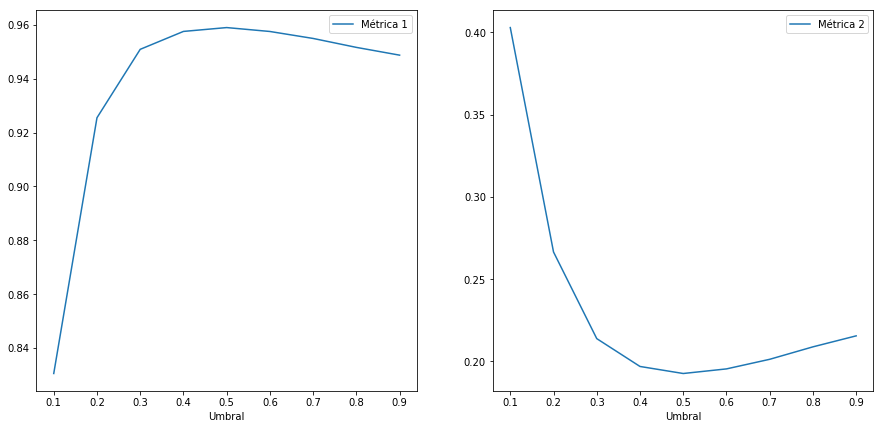

In [44]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(umbrals,metric1)
plt.legend(["Métrica 1"])
plt.xlabel("Umbral")
plt.subplot(122)
plt.plot(umbrals,metric2)
plt.legend(["Métrica 2"])
plt.xlabel("Umbral")
plt.show()

<hr style="height:2px;border:none"/>
# Taxi Trip Duration: Predicción de duración de viaje
<hr style="height:2px;border:none"/>

In [5]:
def rmsle(predicted,real):    
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(abs(predicted[x])+1)
        r = np.log(abs(real[x])+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))

> **a) Cargue los datos de entrenamiento como *dataframes* de pandas. Describa las variables involucradas en el problema, explorando el tipo de datos de que se trata, el número de valores distinto. Grafique adecuadamente el valor a predecir con algún gráfico que resuma su comportamiento, e.g. un histograma, boxplot u otro.**

In [6]:
df = pd.read_csv("train.zip")
df.info()
output = df['trip_duration'].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Se tienen un total de 11 columnas donde la variable a predecir corresponde a trip_duration, los tipos de datos corresponden a tipo objeto, el cual probablemente sea de tipo _date_. Para ver de mejor manera estos tipos de datos se muestran los primeros 5 registros del dataset.

In [7]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Los objetos mencionados anteriormente corresponden a _timestamps_. Por otro lado, se entregan distintas coordenadas para la latitud y la longitud de origen y destino. Se cree que la variable store_and_fwd_flag podría no ser util, debido a que solo indica si la información se guardo en la memoria local del taxi.

In [8]:
for i in df:
    print("Cantidad de valores únicos "+i+": "+str(len(df[i].unique())))

Cantidad de valores únicos id: 1458644
Cantidad de valores únicos vendor_id: 2
Cantidad de valores únicos pickup_datetime: 1380222
Cantidad de valores únicos dropoff_datetime: 1380377
Cantidad de valores únicos passenger_count: 10
Cantidad de valores únicos pickup_longitude: 23047
Cantidad de valores únicos pickup_latitude: 45245
Cantidad de valores únicos dropoff_longitude: 33821
Cantidad de valores únicos dropoff_latitude: 62519
Cantidad de valores únicos store_and_fwd_flag: 2
Cantidad de valores únicos trip_duration: 7417


Se destacan las columnas passenger count y vendor_id puesto que poseen una cantidad muy reducida de valores unicos, se omite store_and_fwd_flag debido a que su impacto podría ser muy poco significativo.

In [9]:
print("Vendor ID:")
print(df['vendor_id'].unique())
print("Passenger Count:")
print(df["passenger_count"].unique())


Vendor ID:
[2 1]
Passenger Count:
[1 6 4 2 3 5 0 7 9 8]


In [10]:
print("Tiempo promedio conductor 1:",df[df["vendor_id"] == 1]["trip_duration"].mean())
print("Tiempo promedio conductor 2:",df[df["vendor_id"] == 2]["trip_duration"].mean())

Tiempo promedio conductor 1: 845.4382435408687
Tiempo promedio conductor 2: 1058.6431638006823


En general se puede notar que el tiempo de viaje promedio entre cada conductor se diferencian por alrededor de 200 segundos, aparentemente los viajes del conductor 2 toman mas tiempo en realizarse que los del conductor 1.

Se analiza la distribución que presenta la duración del viaje por medio de un boxplot y un histograma.

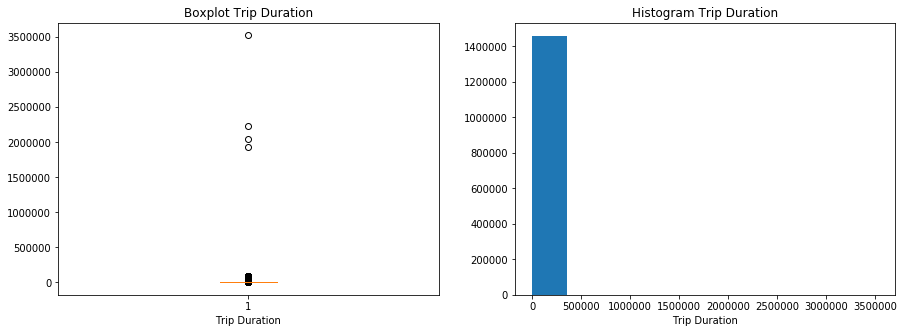

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Boxplot Trip Duration")
plt.boxplot(output)
plt.xlabel("Trip Duration")
plt.subplot(122)
plt.title("Histogram Trip Duration")
plt.hist(output)
plt.xlabel("Trip Duration")
plt.show()

In [12]:
df['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

Debido a la presencia de outliers no es posible determinar una correcta distribución de las duraciones de los viajes, es necesario entonces eliminar las filas que presenten una duración excesiva de tiempo.

>** b) Como puede  observar en los análisis preliminares exiten algunos *outliers* en los datos los cuales pensamos eliminar para que no entorpezca el aprendizaje, además que son muy pocos.**

Se eliminan valores superiores a 100000 segundos

In [13]:
df = df[(df['trip_duration']<=100000)] #10000
#df = df[(df['trip_duration'] >= 120)]
output = df['trip_duration'].values

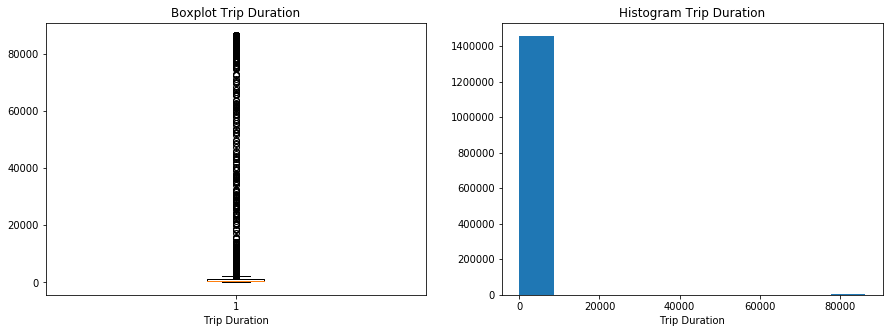

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Boxplot Trip Duration")
plt.boxplot(output)
plt.xlabel("Trip Duration")
plt.subplot(122)
plt.title("Histogram Trip Duration")
plt.hist(output)
plt.xlabel("Trip Duration")
plt.show()

Aún no es posible diferenciar en gran parte la distribución que presenta el set de datos, por lo que muy probablemente, más adelante sea necesario volver a eliminar outliers, no se eliminan los valores en esta instancia para comprobar el comportamiento del learner con dichos outliers cuando se utiliza un escalador robusto.

>** c) La primera operación que realizaremos a los datos como pre-procesamiento será la de extraer/generar características de manera manual de algunos atributos que resulta necesario hacer, como desde la fecha (string) puede ser extraída la hora del día, creando una nueva columna denominada *hour* y de tipo *int* discreto, o bien, para la localización del viaje punto a punto se pueden extraer distintas *medidas de distancia*. Comente sobre el pre-procesamiento realizado.**  

In [15]:
"""extraer caract geograficas"""
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all
def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')
def preprocesar(df):
    df.fillna(0,inplace=True)
    """transformar fechas a tiempos"""
    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['hour'] = pd.to_numeric(df['hour'])
    df['cday'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek #0:lunes,6:domingo
    df['cday'] = pd.to_numeric(df['cday'])
    df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df['month'] = pd.to_numeric(df['month'])
    """Feature Generation"""
    df['distancia_viaje'] = np.sqrt( np.square(df['pickup_longitude']-df['dropoff_longitude']) 
                                    + np.square(df['pickup_latitude']-df['dropoff_latitude'])) #euclideana
    distancia_real_aprox = [ distance(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    df['distancia_viaje_km'] = distancia_real_aprox
    df['grado_direccion'] = [ grado(df['pickup_latitude'].values[i],  #agregar direccion (en base a grado)
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df['season'] = [ seasons[df['month'].values[i] - 1] for i in range(len(df['month'])) ]  #agregar temporada
    df['holiday'] = df['pickup_datetime'].isin(holidays) #holidays
    """ Eliminar columnas -- limpiar"""
    df.drop(["pickup_datetime","dropoff_datetime","id","vendor_id","store_and_fwd_flag"], axis=1,inplace=True)
    df["holiday"] = df["holiday"].astype('category')#a categorico
    """codifica"""
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
preprocesar(df)
df.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,cday,month,distancia_viaje,distancia_viaje_km,grado_direccion,season,holiday
0,1,-73.982155,40.767937,-73.964630,40.765602,455,17,0,3,0.017680,1.498523,99.970196,1,0
1,1,-73.980415,40.738564,-73.999481,40.731152,663,0,6,6,0.020456,1.805510,242.846232,2,0
2,1,-73.979027,40.763939,-74.005333,40.710087,2124,11,1,1,0.059934,6.385108,200.319835,0,0
3,1,-74.010040,40.719971,-74.012268,40.706718,429,19,2,4,0.013438,1.485501,187.262300,1,0
4,1,-73.973053,40.793209,-73.972923,40.782520,435,13,5,3,0.010690,1.188590,179.473585,1,0


In [16]:
df2 = df.copy()

Se generan nuevas caracteristicas de utilidad a partir de los datos que vienen con el dataset por defecto, se obtiene la distancia entre el punto de recogida y el punto de llegada por medio de la distancia euclidiana utilizando las coordenadas de dichos puntos, luego se calcula la distancia en kilometros por medio de la distancia basada en great_circle la cual se basa en la cual calcula la distancia mínima sobre la superficie de una esfera. Debido al contexto del problema quizas seria conveniente utilizar la distancia de manhattan en lugar de distancia euclidiana.

Además con la información del tiempo de recogida y llegada se determina en que época del año, mes, día y hora se realiza el viaje, gracias a esto es posible tomar en cuenta si la hora corresponde a una hora peak y si el día es feriado o no. El caso de la época puede ser de utilidad dado que en días con más lluvia el transito generalmente es más lento.


Se eliminan del dataset columnas que se consideran inutiles para la predicción, estas corresponden a pickup_datetime,dropoff_datetime, id, vendor_id, store_and_fwd_flag.

>** d) Cree las estructuras de los datos a utilizar, además de crear el conjunto de pruebas para validar los modelos ¿Cuáles son las dimensiones de cada conjunto? Normalice los datos, elija algún *scaler* y comente sobre su decisión.**

In [17]:
y = df['trip_duration'].values
df.drop("trip_duration",axis=1,inplace=True)
X = df.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

#scaler = StandardScaler(with_mean=True, with_std=True)
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Se utilizo RobustScaler debido a los outliers que se presentan en el dataset, este escalador funciona eliminando la mediana y utilizando el rango intercuartilico los cuales son estadisticos resistentes a outliers.

Ademas, se genera un conjunto de validación para obtener los hiperparametros optimos para el modelo que se vaya a utilizar.

In [18]:
print("Conjunto X_training:",X_train_scaled.shape)
print("Conjunto y_train:",y_train.shape)
print("Conjunto X_testing:",X_test_scaled.shape)
print("Conjunto y_test:",y_test.shape)

Conjunto X_training: (765786, 13)
Conjunto y_train: (765786,)
Conjunto X_testing: (437592, 13)
Conjunto y_test: (437592,)


El conjunto de entrenamiento posee 1021048 filas de ejemplos con 13 atributos, el conjunto de testing tiene un total de 437592 filas.

In [0]:
#from sklearn.utils import resample

#X_train_sample, y_train_sample = resample(X_train_scaled, y_train, n_samples=100000)
#X_test_sample, y_test_sample = resample(X_test_scaled, y_test, n_samples=50000)

In [0]:
#print("Conjunto X_training:",X_train_sample.shape)
#print("Conjunto y_train:",y_train_sample.shape)
#print("Conjunto X_testing:",X_test_sample.shape)
#print("Conjunto y_test:",y_test_sample.shape)

> **e) En base a la definición del problema de ésta sección y a lo experimentado en la sección 1, escoga un modelo de aprendizaje para experimentar en la predicción de la duración del viaje, comente sobre su decisión. Entrene el modelo escogido, usando parámetros por defecto, sobre la representación escalada generada anteriormente y mida el error de la competencia RMSLE sobre ambos conjuntos, comente.**

<font size="5"> **SVR** </font>

Se genera un SVR lineal con los parametros por defectos, para una cantidad muy alta de ejemplos un SVR lineal se comporta como un SVR comun, la diferencia es que SVR Lineal esta mejor optimizado para realizar el fitting.

In [57]:
def do_SVR(X_train, y_train, c=1.0, epsil=0.1):
    model = LinearSVR(C=c, epsilon=epsil) #SVM, Decision Trees or Neural Network
    model.fit(X_train,y_train)
    return model

In [20]:
model = do_SVR(X_train_scaled, y_train)

<font size="5"> **Arbol de decisión para regresión** </font>

Se utiliza tambien un arbol de decisión para realizar la regresión, los parametros a variar sera la máxima profundidad que podra tener el arbol y la cantidad minima de casos necesarios para generar un split.

In [58]:
from sklearn.tree import DecisionTreeRegressor as Tree

def do_Tree(X_train, y_train, depth=None, min_samples_split=2):
    model = Tree(max_depth=depth, min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    return model

In [22]:
tree = do_Tree(X_train_scaled, y_train)

<font size="5"> **Red neuronal** </font>


El último modelo a trabajar corresponde a una red neuronal con una capa oculta, el parametro a variar correspondera a la cantidad de neuronas que tendran la primera capa y la capa oculta.

In [ ]:
def neural(X_train, y_train, fir=1, sec=1):
    model = Sequential()
    model.add(Dense(units=fir, input_dim=X_train.shape[1], activation='tanh', kernel_initializer='VarianceScaling'))
    model.add(Dense(units=sec, activation='tanh', kernel_initializer='VarianceScaling'))
    model.add(Dense(1, activation='linear', kernel_initializer='VarianceScaling'))
    model.compile(loss="mean_absolute_error", optimizer='adam')
    model.fit(X_train, y_train, epochs=3, verbose=0)
    return model

In [24]:
neur = neural(X_train_scaled, y_train, 1, 1)

In [25]:
print("SVR:")
print("ERROR RMSLE de training: ",rmsle(model.predict(X_train_scaled),y_train))
print("ERROR RMSLE de test: ",rmsle(model.predict(X_test_scaled),y_test))

print("Regressor Tree:")
print("ERROR RMSLE de training: ",rmsle(tree.predict(X_train_scaled),y_train))
print("ERROR RMSLE de test: ",rmsle(tree.predict(X_test_scaled),y_test))

print("Neural:")
print("ERROR RMSLE de training: ",rmsle(neur.predict(X_train_scaled),y_train))
print("ERROR RMSLE de test: ",rmsle(neur.predict(X_test_scaled),y_test))

SVR:
ERROR RMSLE de training:  0.5321643291114637
ERROR RMSLE de test:  0.5338793899347962
Regressor Tree:
ERROR RMSLE de training:  0.0029331975774478636
ERROR RMSLE de test:  0.5834392436042516
Neural:
ERROR RMSLE de training:  [1.26421849]
ERROR RMSLE de test:  [1.26463365]


Se puede notar que el arbol de regresión presenta un posible sobreajuste debido a la diferencia de loss entre el error de training y test, de los 3 modelos escogidos. Como no se tiene claro cual deberia ser la cantidad de neuronas por default se establece como 1 sola unidad por capa. 

De los modelos escogidos se determina que el mejor modelo con la configuración basica corresponde a la SVR.

> **f) Grafique las predicciones generadas por su modelo *vs* el valor real ¿Cuál es el comportamiento esperado? ¿Su resultado se asemeja a éste? ¿Por qué?**

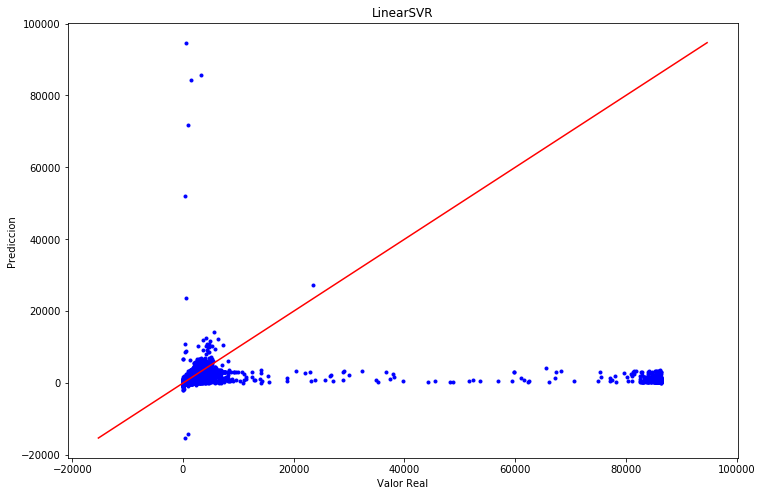

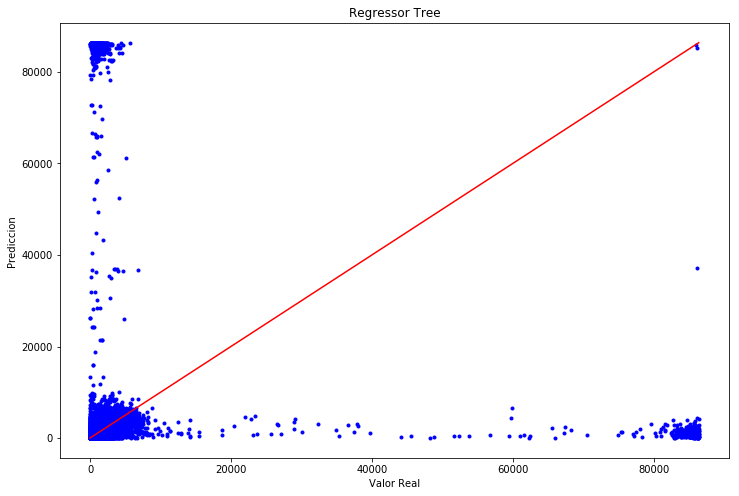

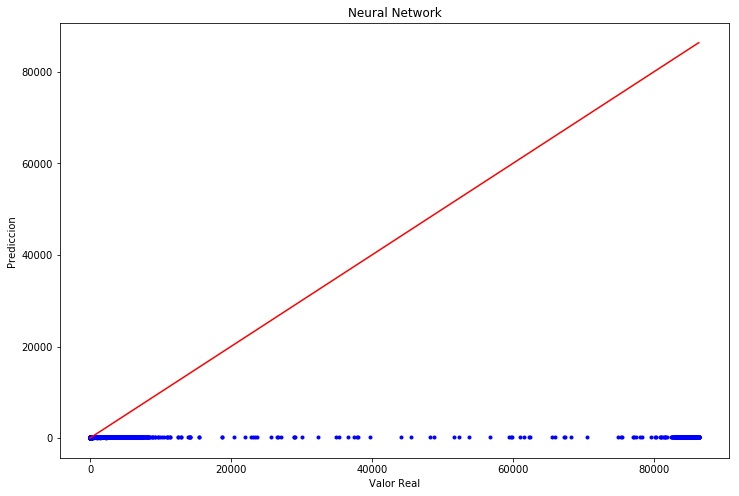

In [26]:
def graficar_predicciones(real,predecido, titulo):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.')
    valor_max = int( np.max( [np.max(predecido),np.max(real)]))
    valor_min = int( np.min( [np.min(predecido),np.min(real)]))
    plt.plot(range(valor_min,valor_max+1), range(valor_min,valor_max+1), color ="r")
    plt.axis('tight')
    plt.title(titulo)
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    plt.show()
graficar_predicciones(y_test,model.predict(X_test_scaled), "LinearSVR")
graficar_predicciones(y_test,tree.predict(X_test_scaled), "Regressor Tree")
graficar_predicciones(y_test,neur.predict(X_test_scaled), "Neural Network")


El comportamiento esperado para cada modelo deberia ser la recta presente en el gráfico donde Valor real es igual a la Predicción. Se puede ver claramente que los resultados no se asemejan a lo que se esperaría optimamente, esto puede deberse a multiples motivos, entre ellos se especula lo siguiente:

- Los valores extremos entorpecen la regresión, perjudicando considerablemente los valores predecidos para cada caso.

- Posiblemente el preprocesamiento de datos no fue optimo para el aprendizaje.

- Existe una clara dificultad para predecir los valores extremos, el comportamiento de la red neuronal falla considerablemente, es necesario agregar una mayor cantidad de neuronas por capa.

> **g) Mejore el desempeño del modelo de aprendizaje definido en e) haciendo modificaciones a los hiper-parámetros del modelo. Por ejemplo, tener ojo con el sobre-ajuste del modelo. Naturalmente, está absolutamente prohibido tomar este tipo de decisiones en función del resultado de pruebas. Debe realizar estas elecciones evaluando sobre el conjunto de validación. Si no desea utilizarlo, y prefiere implementar validación cruzada u otra técnica automática, tiene la ventaja de poder usar el conjunto de validación como parte del entrenamiento. **

Debido a que el set de datos tiene una gran cantidad de casos se determina que no es necesario realizar cross validation, en la practica podria ser lo optimo, pero el tiempo de ejecución es muy alto para la GPU utilizada.

In [27]:
epsilons = [0.001, 0.01, 0.1, 1, 10, 100]
Cs = [0.001, 0.01, 1, 10, 100]


def validation_svr(param, cs=0):
    if param=='Cs':
        params = Cs
    else:
        params = epsilons
    rmsles = list()
    for i in params:
        rmsle_ = 0
        model = LinearSVR()
        if param=="Cs":
            model.set_params(C=i)
        else:
            model.set_params(epsilon=i, C=cs)
        model.fit(X_train_scaled, y_train)
        rmsle_ = rmsle(model.predict(X_val_scaled), y_val)
        rmsles.append(rmsle_)
    return rmsles



Debido a que el tiempo de ejecución de los algoritmos que vienen a continuación es alto se prefiere por ejecutar una vez y guardar los valores optimos para cada modelo por separado.

In [68]:
print("RMSLES de C:",validation_svr('Cs'))

RMSLES de C: [0.6304657495766471, 0.5301939321266655, 0.5314594655658508, 0.5312679026520147, 0.5312881575712181]


En el caso de la SVR se determina que el mejor valor para la fuerza de regulación es 0.01, mientras que el valor de epsilon es 1.

In [60]:
model2 = do_SVR(X_train_scaled, y_train, c=0.01, epsil=1)


In [37]:
neurons = [17, 18, 19, 20, 21, 22, 23, 24, 25]

def validation_neur():
  rmsles = list()
  for i in neurons:
    for j in neurons:
      print("Cantidad de neuronas:",i,j)
      rmsle_ = 0
      model = neural(X_train_scaled, y_train, i, j)
      rmsle_ = rmsle(model.predict(X_val_scaled), y_val)
      rmsles.append(rmsle_)
      if (rmsle_ <= min(rmsle_)):
        print("Best: ",i,j)
  return rmsles
    
    

In [40]:
print("RMSLES de Neuronas: ",validation_neur())

Cantidad de neuronas: 17 17
Best:  17 17
Cantidad de neuronas: 17 18
Best:  17 18
Cantidad de neuronas: 17 19
Best:  17 19
Cantidad de neuronas: 17 20
Best:  17 20
Cantidad de neuronas: 17 21
Best:  17 21
Cantidad de neuronas: 17 22
Best:  17 22
Cantidad de neuronas: 17 23
Best:  17 23
Cantidad de neuronas: 17 24
Best:  17 24
Cantidad de neuronas: 17 25
Best:  17 25
Cantidad de neuronas: 18 17
Best:  18 17
Cantidad de neuronas: 18 18
Best:  18 18
Cantidad de neuronas: 18 19
Best:  18 19
Cantidad de neuronas: 18 20
Best:  18 20
Cantidad de neuronas: 18 21
Best:  18 21
Cantidad de neuronas: 18 22
Best:  18 22
Cantidad de neuronas: 18 23
Best:  18 23
Cantidad de neuronas: 18 24
Best:  18 24
Cantidad de neuronas: 18 25
Best:  18 25
Cantidad de neuronas: 19 17
Best:  19 17
Cantidad de neuronas: 19 18
Best:  19 18
Cantidad de neuronas: 19 19
Best:  19 19
Cantidad de neuronas: 19 20
Best:  19 20
Cantidad de neuronas: 19 21
Best:  19 21
Cantidad de neuronas: 19 22
Best:  19 22
Cantidad de neur

KeyboardInterrupt: 

Se obtiene que la mejor cantidad de neuronas para la primera y segunda capa es de 23 y 22 neuronas, el algoritmo probablemente habría encontrado algo mejor, pero se decidio cortar la ejecución porque la fecha de entrega esta muy proxima, el problema fue que se habia ejecutado por primera vez con otras activaciones, y al cambiarlo no se volvio a ejecutar por temas de tiempo tambien.

In [44]:
neur2 = neural(X_train_scaled, y_train, 23, 22) #15 14

Se determinan los hiperparametros para el arbol de regresión.

In [45]:
max_depth = [2, 3, 4, 5, 10, 15, 20, 30, 40, 50, 60, 70, None]
#max_depth2 = [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
def validation_tree():
    rmsles = list()
    best = float('Inf')
    for i in max_depth2:
        rmsle_ = 0
        model = do_Tree(X_train_scaled, y_train, depth=i)
        rmsle_ = rmsle(model.predict(X_val_scaled), y_val)
        if (rmsle_ <= best):
          best = rmsle_
          print("Best:",i)
        rmsles.append(rmsle_)
    return rmsles

In [ ]:
print(validation_tree())

Se obtiene que la maxima profundidad optima para los casos expuestos es de 20 niveles.

In [53]:
min_samples = [0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 2]
min_samples2 = [0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.9]
def validation_tree_min_samples(depth=None):
  rmsles = list()
  best = float('Inf')
  for i in min_samples2:
    rmsle_ = 0
    model = do_Tree(X_train_scaled, y_train, depth=3, min_samples_split=i)
    rmsle_ = rmsle(model.predict(X_val_scaled), y_val)
    if(rmsle_ <= best):
      best = rmsle_
      print("Best:",i)
    rmsles.append(rmsle_)
  return rmsles

In [ ]:
print(validation_tree_min_samples(depth=20))

De igual manera, se determina que es necesario un minimo del 17% de casos para poder generar un split.

In [61]:
tree2 = do_Tree(X_train_scaled, y_train, depth=20, min_samples_split=0.17)

In [63]:
print("SVR:")
print("ERROR RMSLE de training: ",rmsle(model2.predict(X_train_scaled),y_train))
print("ERROR RMSLE de testing: ",rmsle(model2.predict(X_test_scaled),y_test))

print("Tree:")
print("ERROR RMSLE de training: ",rmsle(tree2.predict(X_train_scaled),y_train))
print("ERROR RMSLE de testing: ",rmsle(tree2.predict(X_test_scaled),y_test))

print("Neural")
print("ERROR RMSLE de training: ",rmsle(neur2.predict(X_train_scaled),y_train))
print("ERROR RMSLE de testing: ",rmsle(neur2.predict(X_test_scaled),y_test))

SVR:
ERROR RMSLE de training:  0.5316504399246774
ERROR RMSLE de testing:  0.5332114298589079
Tree:
ERROR RMSLE de training:  0.5933446361233906
ERROR RMSLE de testing:  0.596746096890838
Neural
ERROR RMSLE de training:  [5.63133628]
ERROR RMSLE de testing:  [5.63112467]


De todos los modelos, el que se vio mas beneficiado por la selección de parametros fue la red neuronal consiguiendo un RMSLE de training y testing inferior a 0.5 (con el cambio comentado anteriormente esto ya no resulta, en caso de querer obtener lo que se tenia anteriormente probar con la red neuronal con 15 y 14 neuronas.

> **h) Mejore el modelo de aprendizaje definido en el punto anterior, g), haciendo modificaciones sobre la representación utilizada para aprender desde los datos, es decir, *feature engineering*. Ya sea añadir nuevas características (puede inspirarse en los __[códigos](https://www.kaggle.com/c/nyc-taxi-trip-duration/kernels)__ de la gente en la competencia), como por ejemplo rescatar algo más de la fecha, como el año o los minutos, o algo de la ubicación y la distancia geográfica. También está la opción de utilizar lo visto en la tarea 1, de *feature selection* con FSS, *Mutual Information*, etc. Sea creativo, este paso le debiese reportar un salto de calidad muy significativo (RMSLE disminuir en 0.1 sobre el conjunto de pruebas).**

Como primera instancia, se eliminan los outliers que aun se mantienen en el set de datos, estos corresponden a valores que superen la duración de 1 hora, puesto que la concentración de datos se encuentra por debajo de esta y se eliminan los viajes con una duración inferior a los 2 minutos.

In [64]:
df2 = df2[(df2['trip_duration']<=3600)] #10000
df2 = df2[(df2['trip_duration'] >= 120)]


In [65]:
df2[df2['distancia_viaje_km'] <= 1.0].describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,cday,month,distancia_viaje,distancia_viaje_km,grado_direccion,season,holiday
count,219139.000000,219139.000000,219139.000000,219139.000000,219139.000000,219139.000000,219139.000000,219139.000000,219139.000000,219139.000000,219139.000000,219139.000000,219139.000000,219139.0
mean,1.657615,-73.979409,40.754079,-73.979336,40.754129,356.147975,13.559065,2.956320,3.466311,0.007418,0.716181,168.762760,0.818791,0.0
std,1.319282,0.152910,0.035840,0.152913,0.035864,252.698087,5.886143,1.921342,1.679904,0.002393,0.221577,106.668254,0.676173,0.0
min,0.000000,-121.933342,34.359695,-121.933304,34.359695,120.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,-73.991394,40.740620,-73.991333,40.740719,208.000000,9.000000,1.000000,2.000000,0.006134,0.600654,68.969073,0.000000,0.0
50%,1.000000,-73.981918,40.755836,-73.981560,40.755909,289.000000,14.000000,3.000000,3.000000,0.007780,0.762747,175.101554,1.000000,0.0
75%,2.000000,-73.968513,40.768230,-73.968758,40.768280,416.000000,18.000000,5.000000,5.000000,0.009073,0.886360,254.205420,1.000000,0.0
max,9.000000,-61.335529,43.911762,-61.335529,43.911762,3590.000000,23.000000,6.000000,6.000000,0.011871,1.000000,359.962358,2.000000,0.0


Se puede ver que existe un porcentaje de viajes que fueron muy cortos, en algunos casos tuvieron una duración no menor lo que ensucia el set de datos, por lo que se decide filtrar todos los viajes que hayan sido de una distancia inferior a 1 km.

In [66]:
df2 = df2[(df2['distancia_viaje_km']>=1.0)]

In [67]:
output2 = df2['trip_duration'].values

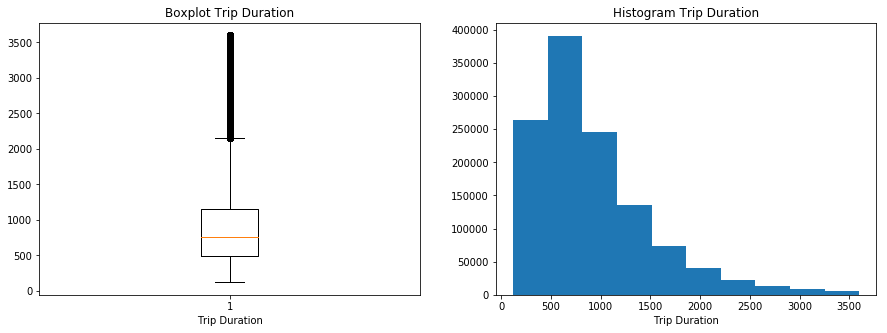

In [68]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Boxplot Trip Duration")
plt.boxplot(output2)
plt.xlabel("Trip Duration")
plt.subplot(122)
plt.title("Histogram Trip Duration")
plt.hist(output2)
plt.xlabel("Trip Duration")
plt.show()

Con la eliminación de los outliers ya es posible determinar una distribución mas explicita de los datos.

Como se comento anteriormente, debido a que el problema se desarrolla en NYC, probablemente la distancia euclidiana no sea la distancia optima para realizar el trabajo, se utiliza en cambio, la distancia de manhattan.

In [69]:
df2['distancia_viaje'] = (abs(df2['pickup_longitude'] - df2['dropoff_longitude']) + 
                                 abs(df2['pickup_latitude'] - df2['dropoff_latitude']))

df2['dif_latitude'] = abs(df2['pickup_latitude'] - df2['dropoff_latitude'])
df2['dif_longitude'] = abs(df2['pickup_longitude'] - df2['dropoff_longitude'])

Revisando notebooks de otros participantes, una idea que se encontró fue armar clusters para las posiciones geográficas usando K-Means[1].El modelo K-Means debe ajustarse solo con la data de entrenamiento y no con la de testing, por lo que se separarán los conjuntos antes de ajustar el modelo.

In [70]:
y2 = df2["trip_duration"].values
df2.drop("trip_duration",axis=1,inplace=True)
X2 = df2.values

Se generan los nuevos sets de entrenamiento, validación y testing.

In [71]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.25, random_state=42)

A continuación se determinan los clusters a los cuales pertenece la posición en la cual se recoge el pasajero y donde se deja.

In [72]:
def setClusters(dataTrain, dataTest, dataVal, clusterNum):
    #coordInicio = data[['pickup_longitude','pickup_latitude']]
    #coordFin = data[['dropoff_longitude','dropoff_latitude']]
    coordIni = list()
    coordFin = list()
    
    for i in dataTrain:
        coordIni.append([i[1],i[2]])
        coordFin.append([i[1],i[2]])
    
    coordIniTest = list()
    coordFinTest = list()
    
    for i in dataTest:
        coordIniTest.append([i[1],i[2]])
        coordFinTest.append([i[1],i[2]])
       
    coordIniVal = list()
    coordFinVal = list()
    
    for i in dataVal:
        coordIniVal.append([i[1],i[2]])
        coordFinVal.append([i[1],i[2]])
        
    
    KMModel = KM(n_clusters = clusterNum)
    KMModel.fit(coordIni)
    
    clusterInicio = np.asarray(KMModel.labels_.tolist())
    clusterTermino = np.asarray(KMModel.predict(coordFin))
    
    auxTrain = dataTrain
    np.c_[auxTrain,clusterInicio,clusterTermino]
    
    clusterInicio = np.asarray(KMModel.predict(coordIniTest))
    clusterTermino = np.asarray(KMModel.predict(coordFinTest))
   
    auxTest = dataTest
    np.c_[auxTest,clusterInicio,clusterTermino]
    
    clusterInicio = np.asarray(KMModel.predict(coordIniVal))
    clusterTermino = np.asarray(KMModel.predict(coordFinVal))
    
    auxVal = dataVal
    np.c_[auxVal,clusterInicio,clusterTermino]
    
    return auxTrain, auxTest, auxVal

X_train2, X_test2, X_val2 = setClusters(X_train2,X_test2,X_val2, 20)

Se vuelve a escalar el set de datos para los nuevos valores generados y filtrados

In [73]:
#scaler2 = StandardScaler(with_mean=True, with_std=True)
scaler2 = RobustScaler(with_centering=True, with_scaling=True)
scaler2.fit(X_train2)
X_train_scaled2 = scaler2.transform(X_train2)
X_test_scaled2 = scaler2.transform(X_test2)
X_val_scaled2 = scaler2.transform(X_val2)

In [74]:
X_train.shape

(765786, 13)

In [75]:
#tree3.feature_importances_
X_train.shape

(765786, 13)

In [0]:

#X: X_trainScaled
#Y: Y_trainScaled
#Nombres
#X:val
#Y:val

def fssSVR(x, y, names_x,x_test,y_test,k = 10000):
    p = x.shape[1]-1
    k = min(p, k)
    names_x = np.array(names_x)
    remaining = [x for x in range(0, p)]
    selected = [p]
    current_score = best_new_score = 0.0
    
    dimensiones = []
    scores = []
    testScores = []
    errorTraining = []
    while remaining and len(selected)<=k :
        score_candidates = []
        score_candidates_test = {}
        error_candidates = {}
        for candidate in remaining:
            #model = LR(fit_intercept=True, n_jobs=1)
            model = LinearSVR(C=0.01, epsilon=1)
            indexes = selected + [candidate]
            x_train = x[:,indexes]
            xtest = x_test[:,indexes]
            
            predictions_train = model.fit(x_train, y).predict(x_train)
            predictions_test = model.predict(xtest)
            
            
            
            #Criterio Código
            rmsle_candidate = rmsle(predictions_train,y)
            rmsle_test = rmsle(predictions_test,y_test)
            
            
            score_candidates.append((rmsle_candidate, candidate))
            
            score_candidates_test[candidate] = rmsle_test
            error_candidates[candidate] = rmsle_candidate
        score_candidates.sort()
        score_candidates[:] = score_candidates[::-1]
        best_new_score, best_candidate = score_candidates.pop()
        
        testScores.append(score_candidates_test[best_candidate])
        errorTraining.append(error_candidates[best_candidate])
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        dimensiones.append(len(selected))
        scores.append(best_new_score)
        #print("selected = %s ..."%names_x[best_candidate])
        #print("totalvars=%d, mse = %f"%(len(indexes),best_new_score))
    return selected, dimensiones, scores, testScores, errorTraining


selected, d, scores, tscores, etrain = fssSVR(X_train_scaled2,y_train2,["0","1","2","3","4","5","6","7","8","9","10","11","12"], X_val_scaled2, y_val2)
print(len(selected))

15


In [0]:
print(selected)
print(tscores)

[14, 9, 3, 5, 10, 6, 7, 1, 4, 2, 13, 12, 11, 8, 0]
[0.5463386788862564, 0.537486041748466, 0.5361980313669277, 0.5353230576605305, 0.5345747661484839, 0.5342381959749188, 0.5337856270353554, 0.5325834615679456, 0.5314531063322578, 0.5310548510081775, 0.5312083318435444, 0.5313160317730006, 0.5314452600991851, 0.5324797026740373]


Finalmente se entrenan los modelos de acuerdo a los parametros determinados anteriormente.

In [76]:
model3 = do_SVR(X_train_scaled2, y_train2, c=0.01, epsil=1)
tree3 = do_Tree(X_train_scaled2, y_train2, depth=20, min_samples_split=0.17)
neur3 = neural(X_train_scaled2, y_train2, 15, 14)

In [77]:
print("LinearSVR:")
print("ERROR RMSLE de training: ",rmsle(model3.predict(X_train_scaled2),y_train2))
print("ERROR RMSLE de test: ",rmsle(model3.predict(X_test_scaled2),y_test2))

print("Regressor Tree:")
print("ERROR RMSLE de training: ",rmsle(tree3.predict(X_train_scaled2),y_train2))
print("ERROR RMSLE de test: ",rmsle(tree3.predict(X_test_scaled2),y_test2))

print("Neural:")
print("ERROR RMSLE de training: ",rmsle(neur3.predict(X_train_scaled2),y_train2))
print("ERROR RMSLE de test: ",rmsle(neur3.predict(X_test_scaled2),y_test2))

LinearSVR:
ERROR RMSLE de training:  0.4135472586329101
ERROR RMSLE de test:  0.4141396411216177
Regressor Tree:
ERROR RMSLE de training:  0.39806642605472475
ERROR RMSLE de test:  0.39894428608699434
Neural:
ERROR RMSLE de training:  [6.13848443]
ERROR RMSLE de test:  [6.13804688]


Se puede ver una mejora considerable para cada uno de los modelos definidos, siendo el modelo SVR lineal el con peor desempeño, y la red neuronal la mejor, llegando a un RMSLE inferior a 0.4, por los motivos definidos anteriormente la red neuronal no funciono correctamente.

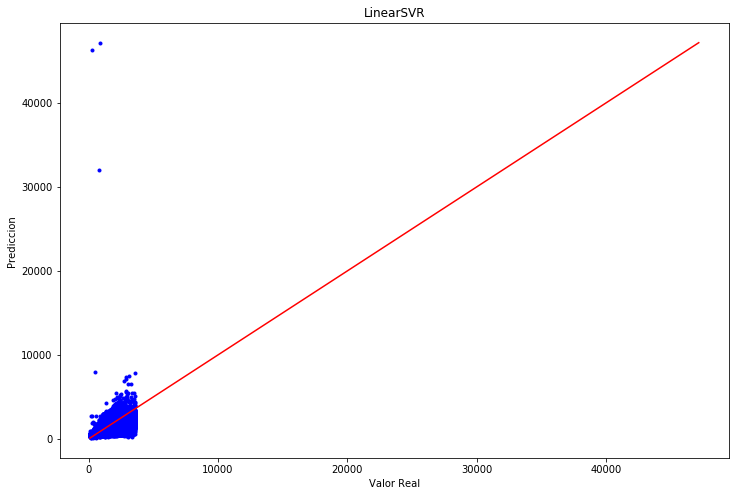

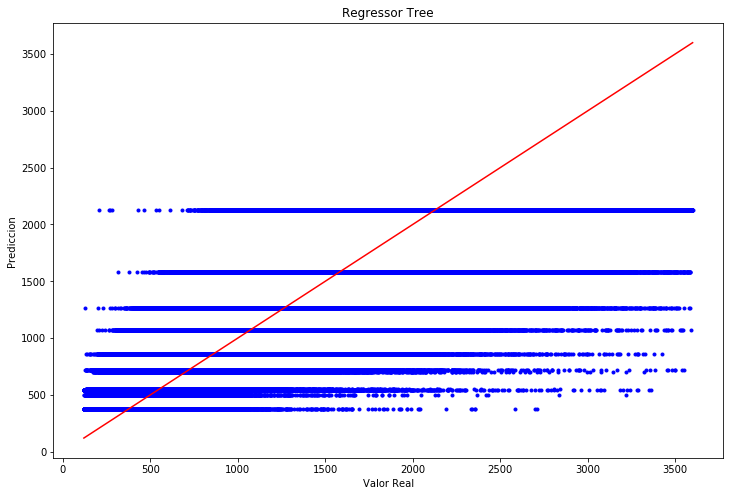

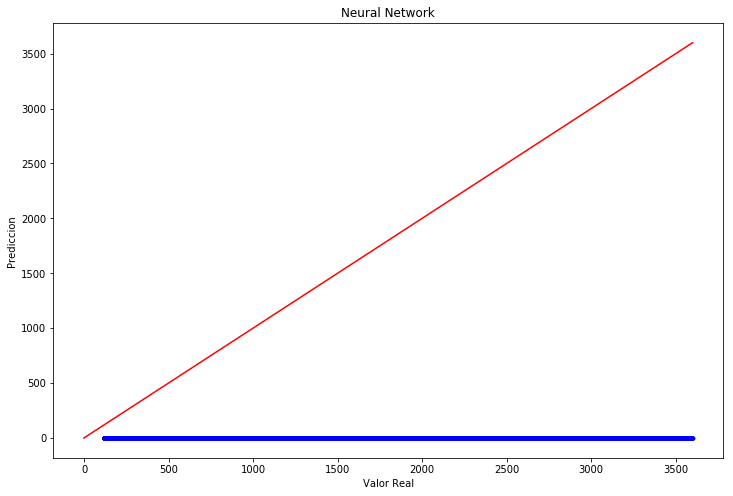

In [78]:
graficar_predicciones(y_test2, model3.predict(X_test_scaled2), "LinearSVR")
graficar_predicciones(y_test2, tree3.predict(X_test_scaled2), "Regressor Tree")
graficar_predicciones(y_test2, neur3.predict(X_test_scaled2), "Neural Network")

Ya se puede ver una mejora en los valores asignados para cada punto, pero la red neuronal presenta una dificultar para predecir tiempos superiores a 1500 segundos. Esto podría deberse al optimizador que utiliza el modelo, sería necesario evaluar dichas metricas para corregir dicho error o quizas a las activaciones definidas, en este caso se utiliza tanh, pero cuando se trabaja con relu o linear existen puntos que se alejan en gran medida de lo aceptable.

>** i) Ahora intente mejorar el modelo de aprendizaje definido en el punto anterior a través de alguna transformación al *output*. Por ejemplo, los histogramas que construyó en el punto a), ası́ como la forma especial de la función de evaluación, sugieren una cierta transformación de la variable respuesta (*output/target*). Una observación importante es que si hace una transformación a la variable respuesta (por ejemplo raı́z cuadrada), debe invertir esta transformación antes de evaluar el desempeño con la métrica de desempeño (por ejemplo, elevar al cuadrado si tomó raı́z cuadrada). Con ésto debería llegar a reducir el RMSLE a menos de 0.5.**

La transformación definida corresponde al logaritmo natural del valor.

In [79]:
def transformar(valor):
    return np.log(valor) #identidad valor**0.5
def destransformar(valor):
    return np.exp(valor) #identidad valor**2
  
y_train_transformed = transformar(y_train2)

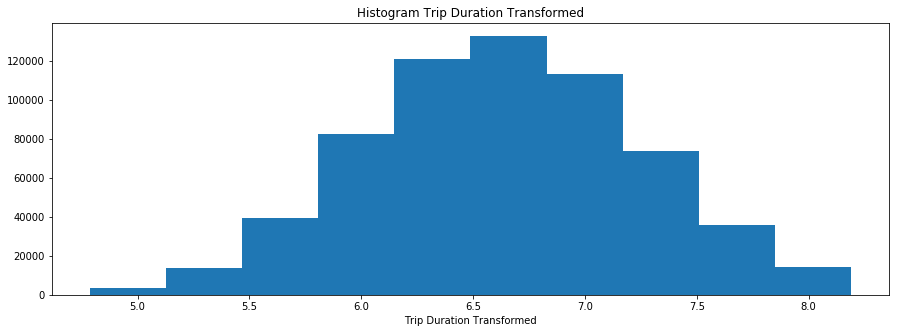

In [80]:
plt.figure(figsize=(15,5))
plt.title("Histogram Trip Duration Transformed")
plt.hist(y_train_transformed)
plt.xlabel("Trip Duration Transformed")
plt.show()

Se puede notar que la nueva distribución de la duración de los tiempos de viaje se asemeja a una distribución normal.

In [81]:
from numpy.random import seed
seed(66)
from tensorflow import set_random_seed
set_random_seed(23)

model4 = do_SVR(X_train_scaled2, y_train_transformed, c=0.01, epsil=1)
tree4 = do_Tree(X_train_scaled2, y_train_transformed, depth=20, min_samples_split=0.17)
neur4 = neural(X_train_scaled2, y_train_transformed, 15, 14)

In [82]:
print("SVR:")
print("ERROR RMSLE de training: ",rmsle(destransformar(model4.predict(X_train_scaled2)), y_train2))
print("ERROR RMSLE de test: ",rmsle(destransformar(model4.predict(X_test_scaled2)), y_test2))

print("Tree:")
print("ERROR RMSLE de training: ",rmsle(destransformar(tree4.predict(X_train_scaled2)), y_train2))
print("ERROR RMSLE de test: ",rmsle(destransformar(tree4.predict(X_test_scaled2)), y_test2))

print("Neural:")
print("ERROR RMSLE de training: ",rmsle(destransformar(neur4.predict(X_train_scaled2)), y_train2))
print("ERROR RMSLE de test: ",rmsle(destransformar(neur4.predict(X_test_scaled2)), y_test2))

SVR:
ERROR RMSLE de training:  0.5209990904698842
ERROR RMSLE de test:  0.4699919375880693
Tree:
ERROR RMSLE de training:  0.40066491381074487
ERROR RMSLE de test:  0.40158068428329063
Neural:
ERROR RMSLE de training:  [5.61072046]


KeyboardInterrupt: 

Se puede notar una mejora en cada uno de los modelos, con la red neuronal aun en primer lugar, el RMSLE para el set de testing es inferior a los 0.33

In [ ]:
#graficar_predicciones(y_test2, destransformar(model4.predict(X_test_scaled2)), "LinearSVR")
#graficar_predicciones(y_test2, destransformar(tree4.predict(X_test_scaled2)), "Regressor Tree")
#graficar_predicciones(y_test2, destransformar(neur4.predict(X_test_scaled2)), "Neural Network")

> **j) Evalúe el efecto de utilizar un ensamblado (combinación) de 2 máquinas de aprendizaje para predecir la duración de un viaje en taxi. Un modelo se especializará en la predicción de la duración de viajes de corta distancia, mientras que el otro modelo se enfocará en la predicción de la duración de viajes de larga distancia. Para la separación considere la media aritmética como el *split*. Hay razones claras para pensar que los patrones son distintos ¿Por qué? Puede mezclar distintos modelos de aprendizaje para cada subconjunto de dato de entrenamiento.**

Se realiza una mascara entre ambos datasets utilizados para comprobar el desempeño del ensamblado en ambos casos.

In [ ]:
#Para outliers
df_temp1 = pd.DataFrame(X_train_scaled)
y_train_1 = pd.DataFrame(y_train)
u1 = np.mean(df_temp1[9])
mask1 = df_temp1[9] <= u1

X_train_11 = df_temp1[mask1].values
y_train_11 = y_train_1[mask1].values
X_train_21 = df_temp1[~mask1].values
y_train_21 = y_train_1[~mask1].values

#Sin Outliers
df_temp2 = pd.DataFrame(X_train_scaled2)
y_train_2 = pd.DataFrame(y_train2)
u2 = np.mean(df_temp2[9])
mask2 = df_temp2[9] <= u2

X_train_12 = df_temp2[mask2].values
y_train_12 = y_train_2[mask2].values
X_train_22 = df_temp2[~mask2].values
y_train_22 = y_train_2[~mask2].values

Se decide utilizar como modelo para los viajes cortos a la red neuronal y para viajes largos al arbol de regresión, en un principio se intento con 2 redes neuronales, pero el desempeño empeoraba considerablemente hasta 0.7

In [ ]:
cortos1 = neural(X_train_11, y_train_11, 15, 14)#do_SVR(X_train_11, y_train_11, c=0.01, epsil=1) # #
largos1 = do_Tree(X_train_21, y_train_21, depth=20, min_samples_split=0.17)

In [ ]:
cortos2 = neural(X_train_12, y_train_12, 15, 14)#do_SVR(X_train_12, y_train_12, c=0.01, epsil=1)#
largos2 = do_Tree(X_train_22, y_train_22, depth=20, min_samples_split=0.17)

La función ensamble recibe el set a evaluar y su respuesta y distribuye los valores correspondientes a viajes cortos para el primer modelo y los largos para el segundo.

In [ ]:
def ensambleM(modelC, modelL, X_test, y_test, mean=0):
    preds = list()
    trues = list()
    test_data = pd.DataFrame(X_test)
    y_test = pd.DataFrame(y_test)
    mask = test_data[9] <= mean
    y_cortos = y_test[mask].values
    y_largos = y_test[~mask].values
    X_cortos = test_data[mask].values
    X_largos = test_data[~mask].values
    pred_cortos = modelC.predict(X_cortos)# destransformar(modelC.predict(X_cortos))
    
    pred_largos = modelL.predict(X_largos)# destransformar(modelL.predict(X_largos))
    for i in pred_cortos:
        preds.append(i)
    for i in pred_largos:
        preds.append(i)
    for i in y_cortos:
        trues.append(i)
    for i in y_largos:
        trues.append(i)
    return preds, trues

In [ ]:
y_pred_o, true1 = ensambleM(cortos1, largos1, X_test_scaled, y_test, u1)
y_pred_s, true2 = ensambleM(cortos2, largos2, X_test_scaled2, y_test2, u2)

In [ ]:
print("Error RSMLE con Outliers:",rmsle(y_pred_o, true1))
print("Error RSMLE sin Outliers:",rmsle(y_pred_s, true2))

El ensamblado no mejora el desempeño del modelo subiendo desde un error de 0.35 hasta 0.45 en el set de testing sin outliers, esto puede deberse a que los parametros definidos en cada caso fueron definidos para un set de datos mayor, al ser la cantidad de datos para viajes largos menores a los viajes cortos probablemente no existen suficientes casos que permitan que el arbol de desición pueda generar un split, entorpeciendo la capacidad de aprendizaje del modelo.

Por otro lado, el ensamblado con outliers si presenta una mejora en su función de perdida disminuyendo de un 0.48 a un 0.46.

<hr style="height:2px;border:none"/>
## 4. Entendimiento de imágenes de personas
<hr style="height:2px;border:none"/>

> **a) Cargue los datos dos dataset de entrenamiento y de pruebas ¿Cuántos datos hay en cada conjunto?**

In [83]:
mat_train = sio.loadmat("./eventrain.mat")
mat_test = sio.loadmat("./eventest.mat")


data_train= mat_train["trcoll"][0][0]
data_test= mat_test["tecoll"][0][0]

In [84]:
print(len(data_train[0]))
print(len(data_test[0]))

3500
1050


Hay un total de 3500 imagenes en el set de entrenamiento y un total de 1050 imagenes en el set de prueba.

> **b) Elija cuál representación utilizará para trabajar los datos y entregárselos como *input* al modelo de aprendizaje a utilizar, recuerde que puede utilizar una combinación de éstos si lo desea. Además extraiga las salidas/*output* del problema, en este caso, como ya se comentó, la edad. Describa los datos utilizados y la cantidad de datos por rango de edad.**

In [85]:
genFeat_train = data_train[0]  #it can be used as representation: contextual features
genFeat_test = data_test[0]
ageClass_train = data_train[1] #target
ageClass_test = data_test[1]
ffcoefs_train = data_train[3]   #it can be used as representation: fisherface space
ffcoefs_test = data_test[3]
faceGist_train = data_train[4]  #it can be used as representation
faceGist_test = data_test[4]

In [86]:
print(genFeat_train.shape)
print(ffcoefs_train.shape)
print(faceGist_train.shape)

(3500, 14)
(3500, 37)
(3500, 600)


La representación contextual features se basa en 'describir' de alguna forma las caracteristicas de la persona que aparece en la image, describiendo entradas como posición central en X o en Y, tamaño relativo al tamaño de otra imagen.

ffcoefs corresponde a una proyección del espacio de fisherface, en el fondo se basa en reducción de dimensionalidad por medio de LDA, según fuentes funciona mejor para imagenes donde hay una gran cantidad de expresiones debido a que la reducción de alguna forma normaliza las caracteristicas.

Se decide por trabajar con ffcoefs.

Para el set de datos se tiene un total de 3500 muestras, las cuales tienen 37 atributos, sin contar el label de la imagen que esta guardada en ageClass.

In [87]:
def do_Scale(X_train, X_test, tipo='standard'):
  if tipo == 'standard':
    scaler = StandardScaler(with_mean=True, with_std=True)
  elif tipo == 'robust':
    scaler = RobustScaler(with_centering=True, with_scaling=True)  
  scaler.fit(X_train)
  aux_train = scaler.transform(X_train)
  aux_test = scaler.transform(X_test)
  return aux_train, aux_test

Para normalizar los pesos de cada atributo se decide utilizar un escalador.

In [88]:
genFeat_train_scaled, genFeat_test_scaled = do_Scale(genFeat_train,genFeat_test, 'robust')
ffcoefs_train_scaled, ffcoefs_test_scaled = do_Scale(ffcoefs_train, ffcoefs_test, 'robust')
faceGist_train_scaled, faceGist_test_scaled = do_Scale(faceGist_train, faceGist_test, 'robust')

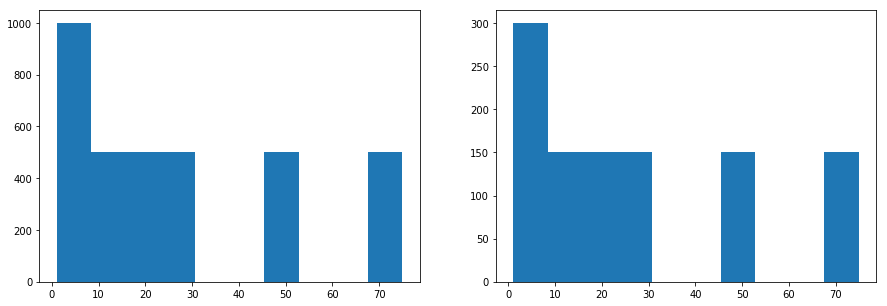

In [89]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(ageClass_train)
plt.subplot(122)
plt.hist(ageClass_test)
plt.show()

In [90]:
uniqueAge_train, counts_train = np.unique(ageClass_train, return_counts=True)
uniqueAge_test, counts_test = np.unique(ageClass_test, return_counts=True)

print("Conjunto de entrenamiento")
for i in range(len(uniqueAge_train)):
  print("Edad: "+str(uniqueAge_train[i])+ "  Cantidad: " + str(counts_train[i]))
  
print("Conjunto de pruebas")
for i in range(len(uniqueAge_test)):
  print("Edad: "+str(uniqueAge_test[i])+ "  Cantidad: " + str(counts_test[i]))   




Conjunto de entrenamiento
Edad: 1  Cantidad: 500
Edad: 5  Cantidad: 500
Edad: 10  Cantidad: 500
Edad: 16  Cantidad: 500
Edad: 28  Cantidad: 500
Edad: 51  Cantidad: 500
Edad: 75  Cantidad: 500
Conjunto de pruebas
Edad: 1  Cantidad: 150
Edad: 5  Cantidad: 150
Edad: 10  Cantidad: 150
Edad: 16  Cantidad: 150
Edad: 28  Cantidad: 150
Edad: 51  Cantidad: 150
Edad: 75  Cantidad: 150


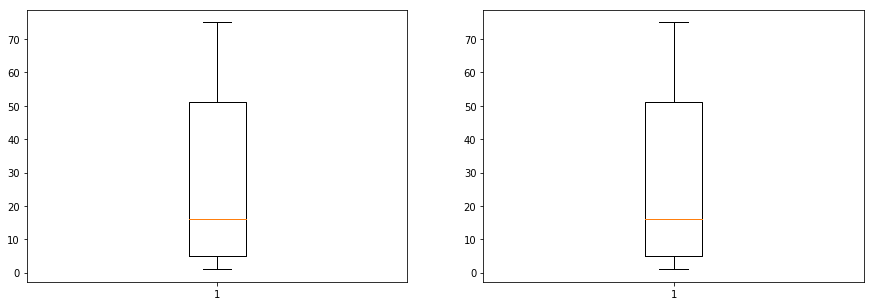

In [91]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.boxplot(ageClass_train)
plt.subplot(122)
plt.boxplot(ageClass_test)
plt.show()

Considerando las edades de los conjuntos, además de la frecuencia de cada edad, se toma la decisión de resolver este problema como uno de clasificación, debido que al existir tan pocos valores distintos para la edad, el usar regresión entregará malos resultados al intentar estimar una función que entregue la edad.

>** c) Defina y entrene modelos de aprendizaje para la inferencia de la edad de la persona a través de la representación escogida, *se espera que experimente con distintas configuraciones, modelos e hiper-parámetros* . Intente llegar a un *MSE* menor a 100 sobre la edad de las personas en el conjunto de pruebas. Recuerde que **NO** puede seleccionar modelos a través del conjunto de pruebas. Visualice sus resultados si estima conveniente.**

Para los modelos se decide utilizar un SVC, una regresión logistica, un arbol de decisión y una red neuronal para clasificación.

In [92]:
def neuralC(X_train, y_train, fir=37, sec=37):
    model = Sequential()
    model.add(Dense(units=fir, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(units=sec, activation='relu'))
    model.add(Dense(units=7, activation='softmax'))
    model.compile(loss="binary_crossentropy", optimizer='adam')
    model.fit(X_train, y_train, epochs=3, verbose=0)
    return model
  
def do_LOGIT(X_train, y_train, c=1.0):
    model = LogisticRegression(solver='liblinear', penalty="l2", C=c)
    model.fit(X_train, y_train)
    return model

def do_SVC(X_train, y_train, c=1.0):
    model = SVM(C=c)
    model.fit(X_train, y_train)
    return model
  
def do_Tree(X_train, y_train, depth=None, min_sample_split=2):
    model = Tree(max_depth=depth, min_samples_split=min_sample_split)
    model.fit(X_train, y_train)
    return model

Debido a la forma en que una red neuronal entrega los resultados como probabilidad de pertenecer a una clase, es necesario utilizar un encoder para generar la matriz de probabilidades.

In [93]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
Y = encoder.fit_transform(ageClass_train)

In [96]:
svc = do_SVC(ffcoefs_train, ageClass_train)
logit = do_LOGIT(ffcoefs_train, ageClass_train)
neural = neuralC(ffcoefs_train, Y)
tree = do_Tree(ffcoefs_train, ageClass_train)

In [97]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

print("Neural:",mean_squared_error(ageClass_train, encoder.inverse_transform(neural.predict(ffcoefs_train))))
print("Logistic Regression:",mean_squared_error(ageClass_train, logit.predict(ffcoefs_train)))
print("SVC:",mean_squared_error(ageClass_train, svc.predict(ffcoefs_train)))
print("Tree:",mean_squared_error(ageClass_train, tree.predict(ffcoefs_train)))

Neural: 58.227714285714285
Logistic Regression: 50.93457142857143
SVC: 54.716857142857144
Tree: 0.07785714285714286


Se puede notar que el modelo con menor perdida corresponde al arbol de desición, pero es sabido que debido a la forma en que clasifica es altisimamente probable que se este en presencia de un sobre ajuste por lo que no se considera en gran medida como un resultado muy confiable.

A continuación se realiza la selección de hiperparámetros, como el set de datos del cual se dispone cuenta con un total de 3500 datos para el entrenamiento es necesario utilizar la técnica de validación cruzada para evaluar el desempeño de cada hiperparámetro.

# Regresión Logistica

In [98]:
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

def cross_val_log(k, X_train):
  MSE = list()
  best = float('Inf')
  for i in C:
    kf = KFold(n_splits=k)
    mse_t = 0
    for train, val in kf.split(X_train):
      model = do_LOGIT(X_train[train], ageClass_train[train], i)
      y_pred = model.predict(X_train[val])
      mse = mean_squared_error(ageClass_train[val], y_pred)
      mse_t += mse
    mse_t = mse_t/k
    if (mse_t <= best):
      print("Best:",mse_t,"C=",i)
      best = mse_t
    MSE.append(mse_t)
  return MS
    

In [ ]:
#print(cross_val_log(5, ffcoefs_train))

El mejor parametro de regularización de la regresión logistica fue de C = 10000

# SVC

In [99]:
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

def cross_val_SVC(k, X_train):
  MSE = list()
  best = float('Inf')
  for i in C:
    kf = KFold(n_splits=k)
    mse_t = 0
    for train, val in kf.split(X_train):
      model = do_SVC(X_train[train], ageClass_train[train], i)
      y_pred = model.predict(X_train[val])
      mse = mean_squared_error(ageClass_train[val], y_pred)
      mse_t += mse
    mse_t = mse_t/k
    if (mse_t <= best):
      print("Best:",mse_t,"C=",i)
      best = mse_t
    MSE.append(mse_t)
  return MSE

In [ ]:
#print(cross_val_SVC(5, ffcoefs_train))

El mejor valor para la fuerza de regularización inversa (c) para la svc fue de 100000.

# Red Neuronal

In [100]:
neurons = [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

def cross_val_neur(k, X_train):
  MSE = list()
  best = float('Inf')
  for i in neurons:
    for j in neurons:
      print("Iteracion:",i,j)
      kf = KFold(n_splits=k)
      mse_t = 0
      for train, val in kf.split(X_train):
        model = neuralC(X_train[train], Y[train], i, j)
        y_pred = model.predict(X_train[val])
        mse = mean_squared_error(encoder.inverse_transform(Y[val]), encoder.inverse_transform(y_pred))
        mse_t += mse
      mse_t = mse_t/k
      if (mse_t <= best):
        besttt = (i, j)
        print("Best:",mse_t,"C=",i,j)
        best = mse_t
      MSE.append(mse_t)
  print(besttt)
  return MSE

In [ ]:
#print(cross_val_neur(5, ffcoefs_train))

La mejor cantidad de neuronas encontradas fue de 35 y 37.

# Tree

Para el arbol de desición se decide determinar 2 parametros, correspondientes a la profundidad máxima permitida y la cantidad minima de muestras para generar una partición.

In [101]:
max_depth = [2, 3, 4, 5, 10, 15, 20, 30, 40, 50, 60, 70, None]
#max_depth2 = [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
def cross_val_tree_depth(k, X_train):
  MSE = list()
  best = float('Inf')
  for i in max_depth:
    kf = KFold(n_splits=k)
    mse_t = 0
    for train, val in kf.split(X_train):
      model = do_Tree(X_train[train], ageClass_train[train], depth=i)
      y_pred = model.predict(X_train[val])
      mse = mean_squared_error(ageClass_train[val], y_pred)
      mse_t += mse
    mse_t = mse_t/k
    if (mse_t <= best):
      print("Best:",mse_t,"depth =",i)
      best = mse_t
    MSE.append(mse_t)
  return MSE

In [ ]:
#print(cross_val_tree_depth(5, ffcoefs_train))

In [102]:
min_sample_split = [.5, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95]
#max_depth2 = [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
def cross_val_tree_depth(k, X_train):
  MSE = list()
  best = float('Inf')
  for i in min_sample_split:
    kf = KFold(n_splits=k)
    mse_t = 0
    for train, val in kf.split(X_train):
      model = do_Tree(X_train[train], ageClass_train[train], depth=2, min_sample_split=i)
      y_pred = model.predict(X_train[val])
      mse = mean_squared_error(ageClass_train[val], y_pred)
      mse_t += mse
    mse_t = mse_t/k
    if (mse_t <= best):
      print("Best:",mse_t,"depth =",i)
      best = mse_t
    MSE.append(mse_t)
  return MSE

In [ ]:
#print(cross_val_tree_depth(10, ffcoefs_train))

De la validación anterior se obtiene que la profundidad optima para el modelo es de 2 niveles y las muestras necesarias para particionar el nodo es de un 40%.

Se crean los nuevos modelos con los parametros determinados por la validación cruzada.

In [103]:
neural2 = neuralC(ffcoefs_train, Y, 35, 37)
r_log = do_LOGIT(ffcoefs_train, ageClass_train, c=10000)
svc2 = do_SVC(ffcoefs_train, ageClass_train, c=100000)
tree2 = do_Tree(ffcoefs_train, ageClass_train, depth=2, min_sample_split=0.4)

Finalmente se evalua cada modelo respecto a la metrica de perdida y accuracy.

In [105]:
print("Logistic Regression Loss:",mean_squared_error(ageClass_test, logit.predict(ffcoefs_test)))
print("Logistic Regression acc:",accuracy_score(ageClass_test, logit.predict(ffcoefs_test)))
print("SVC Loss:",mean_squared_error(ageClass_test, svc2.predict(ffcoefs_test)))
print("SVC acc:",accuracy_score(ageClass_test, svc2.predict(ffcoefs_test)))
print("Neural Loss:",mean_squared_error(ageClass_test, encoder.inverse_transform(neural.predict(ffcoefs_test))))
print("Neural acc:",accuracy_score(ageClass_test, encoder.inverse_transform(neural.predict(ffcoefs_test))))
print("Tree Loss:",mean_squared_error(ageClass_test, tree2.predict(ffcoefs_test)))
#print("Tree acc:",accuracy_score(ageClass_test, tree2.predict(ffcoefs_test)))

Logistic Regression Loss: 60.1647619047619
Logistic Regression acc: 0.32095238095238093
SVC Loss: 52.9847619047619
SVC acc: 0.3904761904761905
Neural Loss: 62.595238095238095
Neural acc: 0.33904761904761904
Tree Loss: 520.7561684252178


El mejor modelo obtenido corresponde al SVC, superando al resto de los modelos en accuracy y loss. 

<hr style="height:2px;border:none"/>
# Referencias
<hr style="height:2px;border:none"/>

- [1] Strength of visualization https://www.kaggle.com/maheshdadhich/strength-of-visualization-python-visuals-tutorial
- [2] https://en.wikipedia.org/wiki/Color_histogram
- [3] Chua, Tat-Seng & Tang, Jinhui & Hong, Richang & Li, Haojie & Luo, Zhiping & Zheng, Yantao. (2009). NUS-WIDE: A real-world web image database from National University of Singapore. 10.1145/1646396.1646452. 